In [1]:
##################################################
# Imports
##################################################

import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd


##################################################
# Params
##################################################

DATA_BASE_FOLDER = './'
SAMPLE_RATE = 16000
HOP_LEN = 512

# Dataset

The dataset is a reduced version of the [`TensorFlow Speech Commands Dataset`](https://www.tensorflow.org/datasets/catalog/speech_commands) and contains audio waveforms of the words:
- `down`, 
- `go`, 
- `left`, 
- `off`, 
- `on`, 
- `right`, 
- `stop`, 
- `up`.


Train / Validation Split
- 1600 train samples, 200 for each class
- 109 validation samples

In [2]:
##################################################
# Load dataset
##################################################

# Load annotations
df_train = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'train.csv'))
df_validation = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'validation.csv'))
labels = sorted(list(set(df_train['word'].values)))

y_train = df_train['word'].map(lambda w: labels.index(w)).values
print(y_train.shape)
y_validation = df_validation['word'].map(lambda w: labels.index(w)).values
print(y_validation)
# Load audio
audio_train = np.load(os.path.join(DATA_BASE_FOLDER, 'train_audio.npy'))
print(labels)


(1600,)
[7 7 7 7 7 7 7 7 7 7 7 7 7 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4
 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1]
['down', 'go', 'left', 'off', 'on', 'right', 'stop', 'up']


# Feature Extraction

The speech is a time series signal and a well known strategy for extracting a good representation of the raw audio is to mimic the processing of the auditory system of the humans. A well established feature representation for speech is the so called "log mel-spectrum". This feature in fact, takes into account how humans perceive both the frequencies and the amplitude of the sound logarithmically. If you want to dig more into this topic [here](https://medium.com/@jonathan_hui/speech-recognition-feature-extraction-mfcc-plp-5455f5a69dd9) you can find some details. 

![auditory-system](https://www.researchgate.net/profile/Morteza_Khaleghi_Meybodi/publication/322343133/figure/fig1/AS:581011472093184@1515535337239/Figure-31-Schematic-of-the-auditory-system-with-its-primary-components-including.png)


For this project these features are precomputed: for each audio waveform of 1 sec duration, the log mel-spectrum is a bi-dimensional representation (frequency vs time) of shape [128, 32]. Here, we first resize the "image" into a [32, 32] matrix and then we flatten the representation into a 32x32 = 1024 vector.

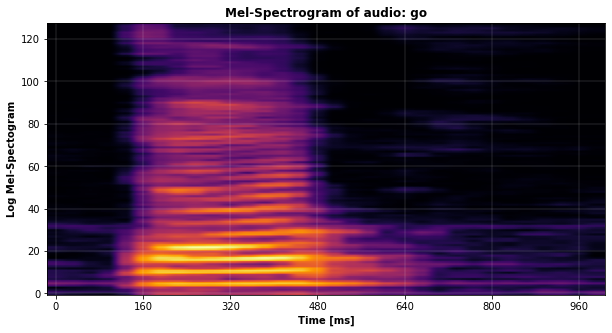

In [3]:
# Load Features
x_train_raw = np.load(os.path.join(DATA_BASE_FOLDER, 'train_feat.npy'))
x_validation_raw = np.load(os.path.join(DATA_BASE_FOLDER, 'validation_feat.npy'))

# Plot audio feature
idx = 1400
time = np.arange(1, SAMPLE_RATE + 1, HOP_LEN) / SAMPLE_RATE
plt.figure(figsize=(10, 5))
plt.title(f'Mel-Spectrogram of audio: {df_train["word"][idx]}', fontweight='bold')
plt.imshow(x_train_raw[idx], aspect='auto', origin='low', cmap='inferno')
xticks = plt.xticks()[0].astype(np.int32)
plt.xticks(xticks[1:-1], [f'{1000 * t:.0f}' for t in time[xticks[1:-1]]])
plt.xlabel('Time [ms]', fontweight='bold')
plt.ylabel('Log Mel-Spectogram', fontweight='bold')
plt.grid(lw=0.4, c='w', alpha=0.4)
plt.show()

# Play audio
ipd.Audio(audio_train[idx], rate=SAMPLE_RATE)

1600
(1600, 32, 32)


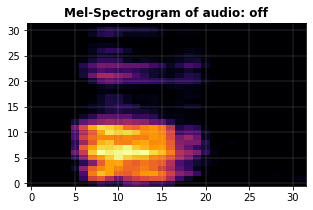

In [4]:
# Resize the features
x_train = []
for x_i in x_train_raw:
    x_train += [cv2.resize(x_i, (32, 32))]
print(len(x_train))
x_train = np.array(x_train)
print(x_train.shape)
x_validation = []
for x_i in x_validation_raw:
    x_validation += [cv2.resize(x_i, (32, 32))]
x_validation = np.array(x_validation)

# Plot audio feature
idx = 1205
plt.figure(figsize=(5, 3))
plt.title(f'Mel-Spectrogram of audio: {df_train["word"][idx]}', fontweight='bold')
plt.imshow(x_train[idx], aspect='auto', origin='low', cmap='inferno')
plt.grid(lw=0.4, c='w', alpha=0.4)
plt.show()

# Play audio
ipd.Audio(audio_train[idx], rate=SAMPLE_RATE)

In [5]:
# Flatten the features
x_train = x_train.reshape(x_train.shape[0], -1)
x_validation = x_validation.reshape(x_validation.shape[0], -1)

print(f'Features dimension size: {x_train.shape[-1]}')
print()
print(x_train.shape)
print(type(x_train))
x = np.ndarray(shape=(2,2))
x_validation.shape

Features dimension size: 1024

(1600, 1024)
<class 'numpy.ndarray'>


(109, 1024)

# Model

Here you have to implement a model (or more models, for finding the most accurate) for classification.

You can use the [`sklearn`](https://scikit-learn.org/stable/) (or optionally other more advanced frameworks such as [`pytorch`](https://pytorch.org/) or [`tensorflow`](https://www.tensorflow.org/)) package that contains a pool of models already implemented that perform classification. (SVMs, NNs, LR, kNN, ...)

In [6]:
##################################################
# Implement you model here
##################################################

import time
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping

###Utility functions and initial configuration of Hyperparameters in variable `params`

In [7]:
##################################################
# Hyperparameter initial configuration
##################################################
global BATCH_SIZE
global EPOCHS
BATCH_SIZE = 128
EPOCHS = 50
params={
    'num_hidden_layers': 1,
    'neurons_per_layer': 1024,
    'dropout_rate':0.2,
    'activation':'relu',
    'optimizer':'adam',
    'learning_rate':5e-4,
    'weights': 'glorot_normal',
}

print(EPOCHS)
print(BATCH_SIZE)
params

50
128


{'activation': 'relu',
 'dropout_rate': 0.2,
 'learning_rate': 0.0005,
 'neurons_per_layer': 1024,
 'num_hidden_layers': 1,
 'optimizer': 'adam',
 'weights': 'glorot_normal'}

In [8]:
##################################################
# Model Creation
##################################################

def create_model(parameters, compile=True):
  num_hidden_layers = parameters['num_hidden_layers']
  num_neurons = parameters['neurons_per_layer']
  activation = parameters['activation']
  dropout= parameters['dropout_rate']
  learning_rate= parameters['learning_rate']
  opt = parameters['optimizer'].lower()
  weights = parameters['weights']

  # Building model
  model = Sequential()
  # Input layer
  model.add(Dense(num_neurons, input_dim=1024, activation=activation, 
                  name="Layer_1",kernel_initializer=weights))
  model.add(Dropout(dropout))
  # Hidden layers
  if num_hidden_layers>1:
    for i in range(num_hidden_layers-1):
      model.add(Dense(num_neurons, activation=activation, 
                      name="Layer_" + str(i+2), 
                      kernel_initializer=weights))
      model.add(Dropout(dropout))
 
  # Output layer
  model.add(Dense(8, activation='softmax', name = 'Output_layer', kernel_initializer=weights))
  
  # Optimizers
  if opt == 'adam':
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  elif opt == 'rmsprop':
      optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
  elif opt== 'sgd':
      optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  elif opt == 'adagrad':
      optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
  elif opt == 'adadelta':
      optimizer= tf.keras.optimizers.Adadelta(learning_rate=learning_rate)
  elif opt == 'adamax':
      optimizer= tf.keras.optimizers.Adamax(learning_rate=learning_rate)
  elif opt == 'nadam':
      optimizer= tf.keras.optimizers.Nadam(learning_rate=learning_rate) 
  elif opt == 'ftrl':
      optimizer= tf.keras.optimizers.Ftrl(learning_rate=learning_rate)   
  else:
    print("optimizers " + str(opt) + " doesn't exist!")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  # Compile model
  if compile:
    model.compile(optimizer=opt,loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])
  else:
    return model
  
  return model

create_model(params).summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
Output_layer (Dense)         (None, 8)                 8200      
Total params: 1,057,800
Trainable params: 1,057,800
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Function that returns best hypeparamter for a dictionary with list 
# of history object as values
def best_parameter(acc_dic, loss_dic):
  best_acc = max(acc_dic.values())
  best_loss= min(loss_dic.values())
  pos_acc = list(acc_dic.values()).index(best_acc)
  pos_loss = list(loss_dic.values()).index(best_loss)
  p_acc = list(acc_dic.keys())[pos_acc]
  p_loss = list(loss_dic.keys())[pos_loss]
  print("best parameter acc is: " + str(p_acc) + 
    " with acc = " + str(best_acc))
  print("best parameter loss is: " + str(p_loss) + 
    " with loss = " + str(best_loss))
  return p_acc, p_loss


In [10]:
# Boiler code to print graphs
def plot_metric(his, p_name, p_value):
  if p_value==-1:
    p_value=''
  plt.figure(figsize=(20,7))
  plt.subplot(1,2,1)
  plt.plot(his.history['accuracy'], lw=4, zorder=5,
            label = 'train p_name: ' + str(p_name)+
           ' = ' + str(p_value))
  plt.plot(his.history['val_accuracy'], lw=4, zorder=5,
            label='validation')
  plt.grid(True, zorder=0, ls='--')
  plt.ylabel('accuracy',fontweight='bold', fontsize=15)
  plt.xlabel('epoch', fontweight='bold', fontsize=15)
  plt.legend(fontsize='x-large', loc='best')

  plt.subplot(1,2,2)
  plt.plot(his.history['loss'], lw=4, zorder=5,
            label = 'train p_name: '+str(p_name)+
           ' = ' + str(p_value))
  plt.plot(his.history['val_loss'], lw=4, zorder=5,
            label='validation')
  plt.grid(True, zorder=0, ls='--')
  plt.ylabel('Loss',fontweight='bold', fontsize=15)
  plt.xlabel('epoch', fontweight='bold', fontsize=15)
  plt.legend(fontsize='x-large', loc='best')
  plt.show()



In [11]:
def check_parameter(parameter_name, parameter_value, verbose=0, callbacks=0):
  print("I am computing the parameter " + parameter_name +
        "  for these values: " + str(parameter_value))
  start_time = time.time()
  epochs_history = {}
  total_acc={}
  total_loss={}
  es = EarlyStopping(monitor='val_accuracy', mode='max',patience=9,
                   min_delta=0,verbose=1)
  for value in parameter_value:
    params[parameter_name]=value
    if verbose==1:
      print("computing for value " + str(value) + ":\n")
      # print(params)
    m=  create_model(params)
    if callbacks==1:

      his = m.fit(x_train,y=y_train, 
              validation_data=(x_validation, y_validation), 
              epochs=EPOCHS ,
              batch_size=BATCH_SIZE,callbacks=[es] ,verbose =0)
    else:
      his = m.fit(x_train,y=y_train, 
              validation_data=(x_validation, y_validation), 
              epochs=EPOCHS ,
              batch_size=BATCH_SIZE,verbose =0)
    epochs_history[value] = his
    predictions = m.predict(x_validation)
    y_pred = np.argmax(predictions, axis = 1)
    metrics = m.evaluate(x_validation, y_validation, verbose=0)
    total_acc[value]=round(metrics[1],3)
    total_loss[value]=round(metrics[0],3)
    if verbose==1:
      print("accuracy: "+ str(parameter_name) + " value "
            +str(value))
      print(round(metrics[1],4))
      print('-'*20)
  if verbose==1:
    print("EXECUTION TIME: " + str(time.time() - start_time) + " seconds")
  
  return total_acc, total_loss, epochs_history

In [12]:
def optimal_hyperparameter(p_name, p_values, verbose=0, max_iterations=5, callbacks=1):
  es = EarlyStopping(monitor='val_accuracy', mode='max',patience=9, min_delta=0, 
                    verbose=1)
  d = {}
  for value in p_values:
    l=[]
    params[p_name]=value
    # print("PARAMS " + str(params))
    # print("VALUE : " + value)
    m=  create_model(params)
    for i in range(max_iterations):
      if callbacks==1:
        his = m.fit(x_train,y=y_train, 
            validation_data=(x_validation, y_validation), 
            epochs=EPOCHS ,
            batch_size=BATCH_SIZE,callbacks=[es] ,verbose =verbose)
      else:
        his = m.fit(x_train,y=y_train, 
            validation_data=(x_validation, y_validation), 
            epochs=EPOCHS ,
            batch_size=BATCH_SIZE,verbose =verbose)
      metrics = m.evaluate(x_validation, y_validation, verbose=verbose)
      l.append(metrics[1])
    print(l)
    d[value] = np.mean(l)
    print(d)
  return d

#Hyparameter tuning






###1. Layers and Neurons


In [13]:
layers=[1,5,10,15]
acc, loss, his = check_parameter('num_hidden_layers', layers, verbose=1, callbacks=1)


I am computing the parameter num_hidden_layers  for these values: [1, 5, 10, 15]
computing for value 1:

Epoch 00024: early stopping
accuracy: num_hidden_layers value 1
0.6422
--------------------
computing for value 5:

Epoch 00046: early stopping
accuracy: num_hidden_layers value 5
0.6239
--------------------
computing for value 10:

Epoch 00014: early stopping
accuracy: num_hidden_layers value 10
0.1651
--------------------
computing for value 15:

Epoch 00010: early stopping
accuracy: num_hidden_layers value 15
0.1101
--------------------
EXECUTION TIME: 13.00933289527893 seconds


from the code bove I can see that when number layers are >=10 the accuracy is low, so I try from 5 to 9

In [14]:
layers=[5,6,7,8,9]
acc, loss, his = check_parameter('num_hidden_layers', 
                                 layers, verbose=1, callbacks=0)

I am computing the parameter num_hidden_layers  for these values: [5, 6, 7, 8, 9]
computing for value 5:

accuracy: num_hidden_layers value 5
0.6606
--------------------
computing for value 6:

accuracy: num_hidden_layers value 6
0.5963
--------------------
computing for value 7:

accuracy: num_hidden_layers value 7
0.5229
--------------------
computing for value 8:

accuracy: num_hidden_layers value 8
0.4128
--------------------
computing for value 9:

accuracy: num_hidden_layers value 9
0.2569
--------------------
EXECUTION TIME: 23.307039499282837 seconds


For value 7,8 and 9 the accuracy is very low, I try the range 1-6

In [15]:
layers=[1,2,3,4,5,6]

acc, loss, his = check_parameter('num_hidden_layers', 
                                 layers, verbose=1, callbacks=0)

I am computing the parameter num_hidden_layers  for these values: [1, 2, 3, 4, 5, 6]
computing for value 1:

accuracy: num_hidden_layers value 1
0.7615
--------------------
computing for value 2:

accuracy: num_hidden_layers value 2
0.7431
--------------------
computing for value 3:

accuracy: num_hidden_layers value 3
0.6239
--------------------
computing for value 4:

accuracy: num_hidden_layers value 4
0.6514
--------------------
computing for value 5:

accuracy: num_hidden_layers value 5
0.6147
--------------------
computing for value 6:

accuracy: num_hidden_layers value 6
0.6514
--------------------
EXECUTION TIME: 23.448192358016968 seconds


Now I get the mean in order to evaluate the best parameter

In [16]:
layers=[1,2,3,4,5,6]
d = optimal_hyperparameter('num_hidden_layers', layers, callbacks=1)

Epoch 00037: early stopping
Epoch 00020: early stopping
Epoch 00022: early stopping
Epoch 00015: early stopping
Epoch 00012: early stopping
[0.7155963182449341, 0.8073394298553467, 0.8073394298553467, 0.853210985660553, 0.8256880640983582]
{1: 0.8018348455429077}
Epoch 00024: early stopping
Epoch 00010: early stopping
Epoch 00013: early stopping
Epoch 00025: early stopping
Epoch 00030: early stopping
[0.5504587292671204, 0.5779816508293152, 0.5688073635101318, 0.6697247624397278, 0.6880733966827393]
{1: 0.8018348455429077, 2: 0.6110091805458069}
Epoch 00035: early stopping
Epoch 00018: early stopping
Epoch 00011: early stopping
Epoch 00011: early stopping
Epoch 00012: early stopping
[0.47706422209739685, 0.6330274939537048, 0.6880733966827393, 0.6146789193153381, 0.6605504751205444]
{1: 0.8018348455429077, 2: 0.6110091805458069, 3: 0.6146789014339447}
Epoch 00013: early stopping
Epoch 00018: early stopping
Epoch 00018: early stopping
Epoch 00015: early stopping
[0.642201840877533, 0.66

In [19]:
best_value = max(d.values())
best_layer=list(d.keys())[list(d.values()).index(best_value)]
print("best_layer: " + str(best_layer) + " with value: " + 
      str(best_value))
params['num_hidden_layers']=best_layer
print("-"*30)
print("Hyperparameter:")
params


best_layer: 1 with value: 0.8018348455429077
------------------------------
Hyperparameter:


{'activation': 'relu',
 'dropout_rate': 0.2,
 'learning_rate': 0.0005,
 'neurons_per_layer': 1024,
 'num_hidden_layers': 1,
 'optimizer': 'adam',
 'weights': 'glorot_normal'}

In [20]:
layers=[1]

acc, loss, his = check_parameter('num_hidden_layers', 
                                 layers, verbose=1, callbacks=0)

I am computing the parameter num_hidden_layers  for these values: [1]
computing for value 1:

accuracy: num_hidden_layers value 1
0.789
--------------------
EXECUTION TIME: 3.5459401607513428 seconds


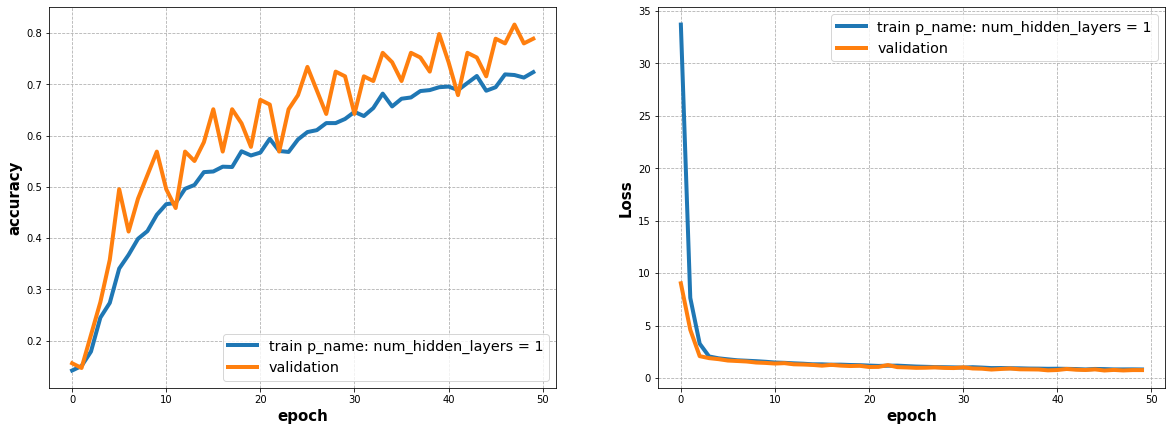

In [21]:
for value in layers:
  plot_metric(his[value], 'num_hidden_layers', value)

###1.2 Neurons

In [22]:
neurons=[10,100,1024,1024*10, 1024*20]
print(params)
acc, loss, his = check_parameter('neurons_per_layer', neurons,callbacks=1, verbose=1 )


{'num_hidden_layers': 1, 'neurons_per_layer': 1024, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0005, 'weights': 'glorot_normal'}
I am computing the parameter neurons_per_layer  for these values: [10, 100, 1024, 10240, 20480]
computing for value 10:

Epoch 00010: early stopping
accuracy: neurons_per_layer value 10
0.156
--------------------
computing for value 100:

Epoch 00010: early stopping
accuracy: neurons_per_layer value 100
0.1193
--------------------
computing for value 1024:

Epoch 00035: early stopping
accuracy: neurons_per_layer value 1024
0.7248
--------------------
computing for value 10240:

accuracy: neurons_per_layer value 10240
0.8073
--------------------
computing for value 20480:

Epoch 00024: early stopping
accuracy: neurons_per_layer value 20480
0.6422
--------------------
EXECUTION TIME: 13.023985385894775 seconds


Clearly for 10 or 100 neurons accuracy is low because I have 1024 as dimension of input. For 1024 x 10 and 1024 x 20 I have good accuracy, but I can notice that it's not so distant from 1024. I can imagine that if I increase number of neurons my Model doesn't learn more.

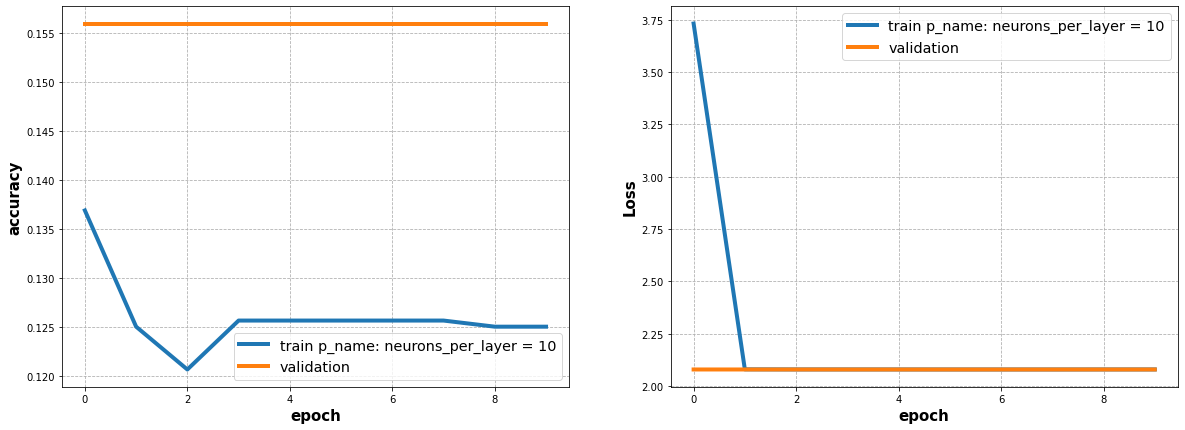

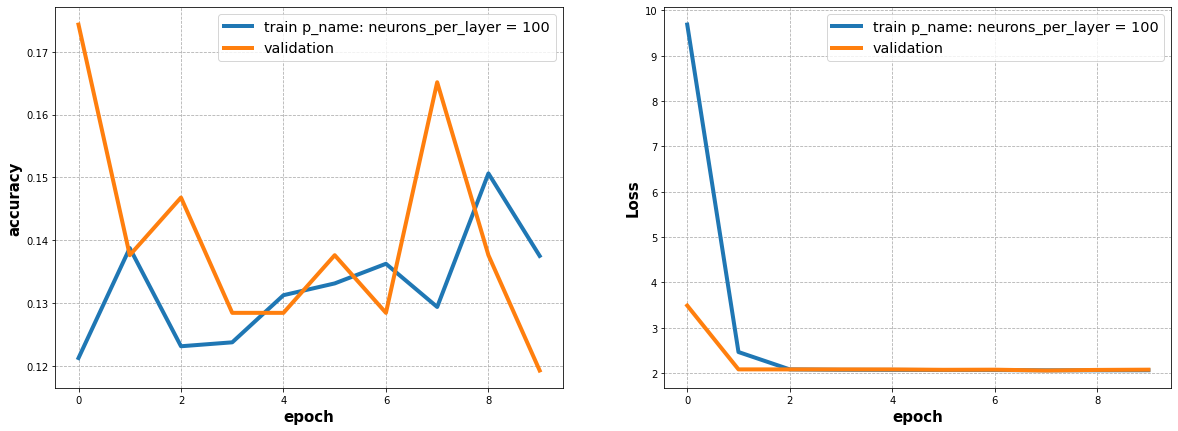

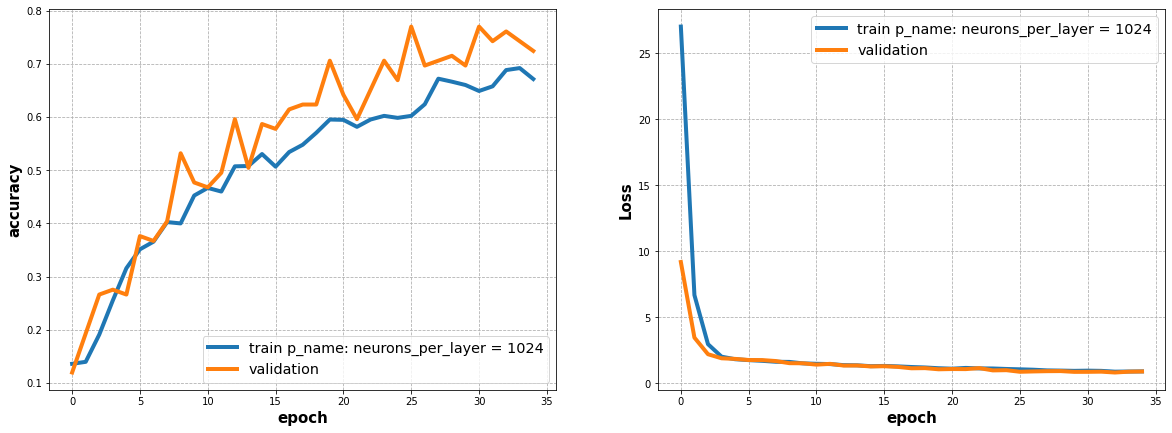

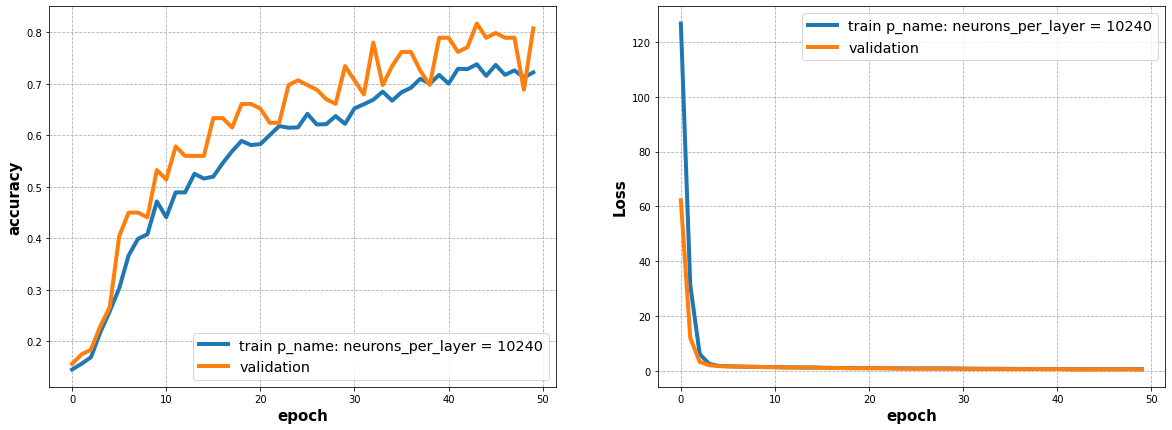

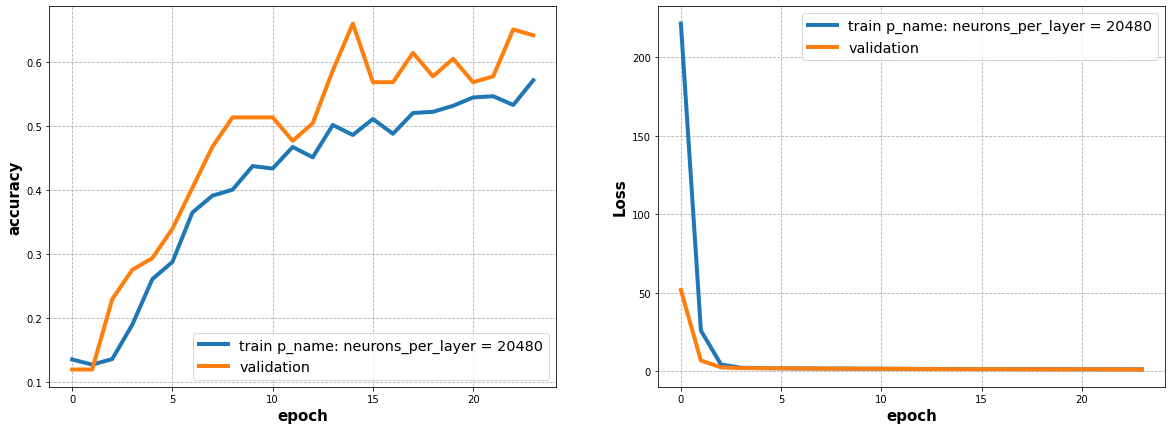

In [23]:
for value in neurons:
  plot_metric(his[value], 'neurons_per_layer', value)

In [24]:
neurons=[1024, 1024*10, 1024*20]
d_neurons = optimal_hyperparameter('neurons_per_layer', neurons)


Epoch 00037: early stopping
Epoch 00031: early stopping
Epoch 00017: early stopping
Epoch 00018: early stopping
Epoch 00010: early stopping
[0.6697247624397278, 0.7706422209739685, 0.7981651425361633, 0.7981651425361633, 0.8073394298553467]
{1024: 0.768807339668274}
Epoch 00021: early stopping
Epoch 00013: early stopping
Epoch 00010: early stopping
Epoch 00010: early stopping
[0.7064220309257507, 0.8440366983413696, 0.8348624110221863, 0.853210985660553, 0.8623853325843811]
{1024: 0.768807339668274, 10240: 0.8201834917068481}
Epoch 00030: early stopping
Epoch 00015: early stopping
Epoch 00014: early stopping
Epoch 00020: early stopping
Epoch 00013: early stopping
[0.6880733966827393, 0.752293586730957, 0.7431192398071289, 0.78899085521698, 0.7706422209739685]
{1024: 0.768807339668274, 10240: 0.8201834917068481, 20480: 0.7486238598823547}


In [26]:
print(d_neurons)

{1024: 0.768807339668274, 10240: 0.8201834917068481, 20480: 0.7486238598823547}


From the cell above I can confirm that my model doesn't improve in a tangible way. Now I try with neurons near 1024

In [27]:
neurons=[1024, 1024*2, 1024*3, 1024*4, 1024*5, 1024*6]
print(params)
acc, loss, his = check_parameter('neurons_per_layer', neurons,callbacks=0, verbose=1 )

{'num_hidden_layers': 1, 'neurons_per_layer': 20480, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0005, 'weights': 'glorot_normal'}
I am computing the parameter neurons_per_layer  for these values: [1024, 2048, 3072, 4096, 5120, 6144]
computing for value 1024:

accuracy: neurons_per_layer value 1024
0.7523
--------------------
computing for value 2048:

accuracy: neurons_per_layer value 2048
0.8073
--------------------
computing for value 3072:

accuracy: neurons_per_layer value 3072
0.7706
--------------------
computing for value 4096:

accuracy: neurons_per_layer value 4096
0.7982
--------------------
computing for value 5120:

accuracy: neurons_per_layer value 5120
0.789
--------------------
computing for value 6144:

accuracy: neurons_per_layer value 6144
0.7706
--------------------
EXECUTION TIME: 21.648478746414185 seconds


In [30]:
neurons=[1024, 1024*2, 1024*3, 1024*4, 1024*5, 1024*6]
d_neurons = optimal_hyperparameter('neurons_per_layer', neurons,
                                   max_iterations=10)


Epoch 00014: early stopping
Epoch 00012: early stopping
Epoch 00019: early stopping
Epoch 00015: early stopping
Epoch 00018: early stopping
Epoch 00013: early stopping
Epoch 00010: early stopping
Epoch 00015: early stopping
Epoch 00015: early stopping
[0.8165137767791748, 0.7798165082931519, 0.8256880640983582, 0.853210985660553, 0.8623853325843811, 0.853210985660553, 0.853210985660553, 0.8623853325843811, 0.8348624110221863, 0.8165137767791748]
{1024: 0.8357798159122467}
Epoch 00038: early stopping
Epoch 00036: early stopping
Epoch 00021: early stopping
Epoch 00016: early stopping
Epoch 00012: early stopping
Epoch 00021: early stopping
Epoch 00010: early stopping
Epoch 00010: early stopping
Epoch 00010: early stopping
Epoch 00012: early stopping
[0.6697247624397278, 0.8165137767791748, 0.8440366983413696, 0.8440366983413696, 0.7981651425361633, 0.8807339668273926, 0.853210985660553, 0.8440366983413696, 0.8073394298553467, 0.8715596199035645]
{1024: 0.8357798159122467, 2048: 0.82293577

In [31]:
best_value = max(d_neurons.values())
best_neurons=list(d_neurons.keys())[list(d_neurons.values()).index(best_value)]
params['neurons_per_layer'] = best_neurons
print("Best number of neurons: " + str(best_neurons)+ " with value: "+
      str(best_value))
print("-"*30)
print("Hyperparameter:")
params

Best number of neurons: 1024 with value: 0.8357798159122467
------------------------------
Hyperparameter:


{'activation': 'relu',
 'dropout_rate': 0.2,
 'learning_rate': 0.0005,
 'neurons_per_layer': 1024,
 'num_hidden_layers': 1,
 'optimizer': 'adam',
 'weights': 'glorot_normal'}

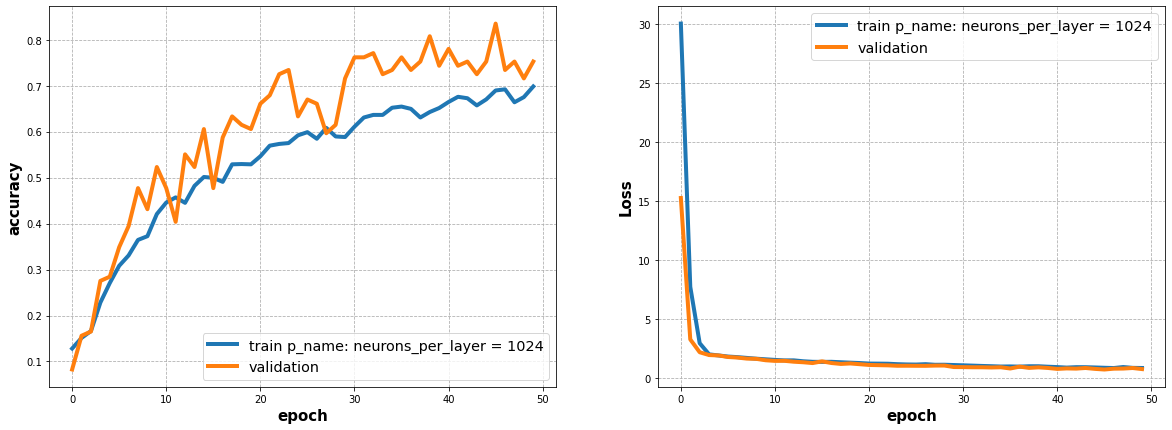

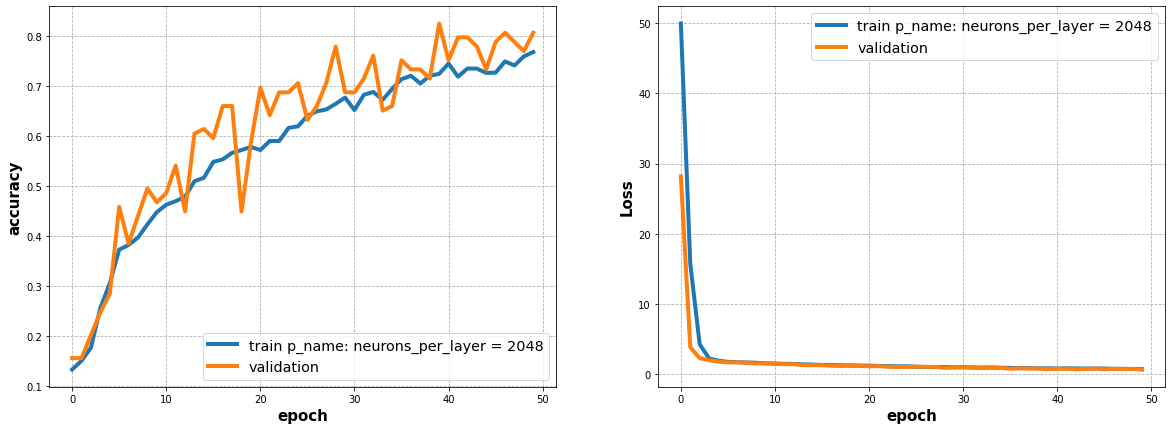

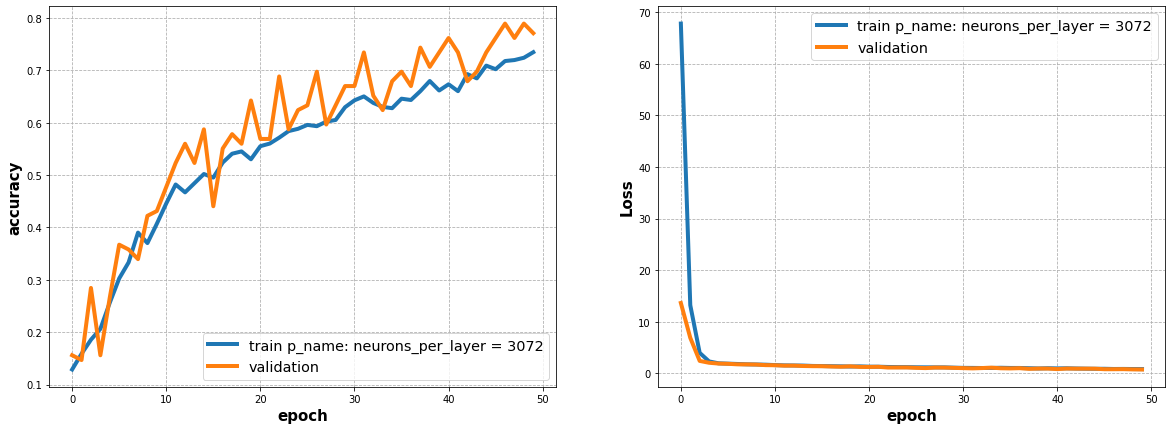

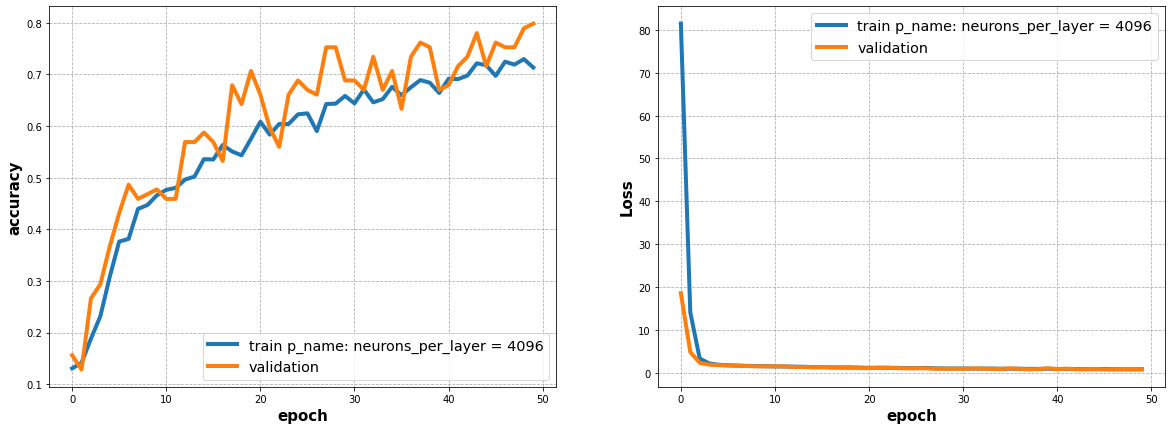

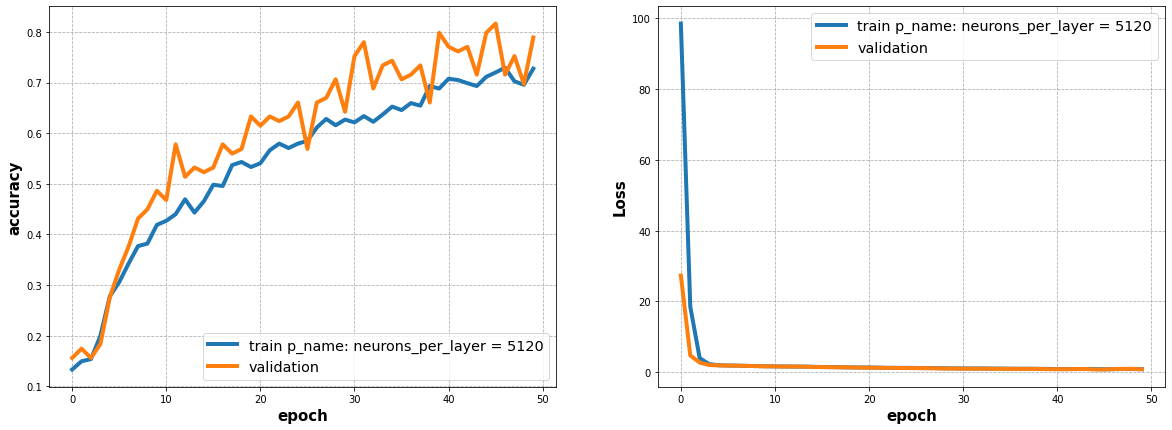

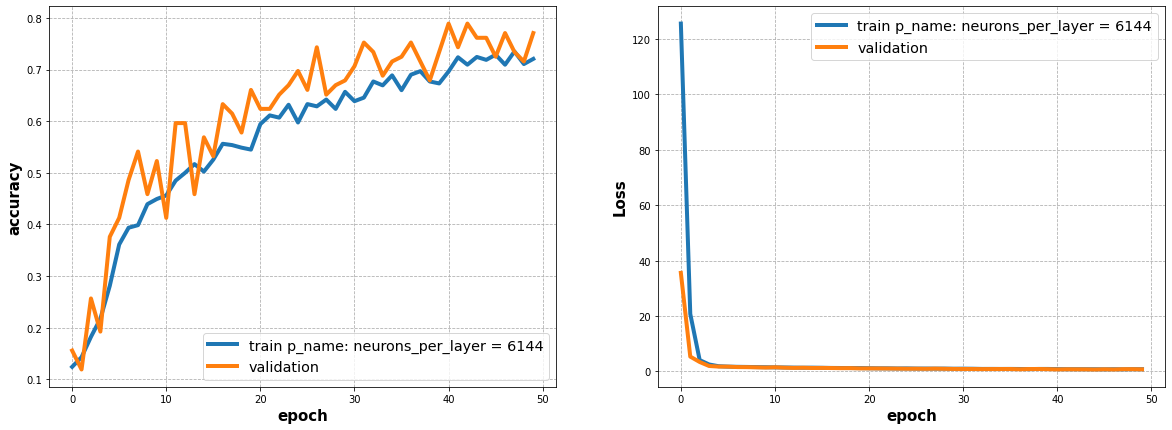

In [32]:
for value in neurons:
  plot_metric(his[value], 'neurons_per_layer', value)

###2. Activation

In [33]:
activation = ['elu','selu','softmax', 'softplus', 'softsign', 
              'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
acc, loss, his = check_parameter('activation', 
                                 activation, verbose=1, callbacks=0)

I am computing the parameter activation  for these values: ['elu', 'selu', 'softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
computing for value elu:

accuracy: activation value elu
0.7706
--------------------
computing for value selu:

accuracy: activation value selu
0.7523
--------------------
computing for value softmax:

accuracy: activation value softmax
0.2294
--------------------
computing for value softplus:

accuracy: activation value softplus
0.8073
--------------------
computing for value softsign:

accuracy: activation value softsign
0.5596
--------------------
computing for value relu:

accuracy: activation value relu
0.7615
--------------------
computing for value tanh:

accuracy: activation value tanh
0.3945
--------------------
computing for value sigmoid:

accuracy: activation value sigmoid
0.4679
--------------------
computing for value hard_sigmoid:

accuracy: activation value hard_sigmoid
0.5138
--------------------
computing fo

From cell above I can eliminate surely for low accuracy: `linear`, `hard_sigmoid`, `sigmoid`, `tanh`, `softsign` e `softmax`

In [34]:
activation = ['elu','selu', 'softplus','relu']
d_activation = optimal_hyperparameter('activation', activation, max_iterations=15)


Epoch 00021: early stopping
Epoch 00028: early stopping
Epoch 00014: early stopping
Epoch 00014: early stopping
Epoch 00010: early stopping
Epoch 00011: early stopping
Epoch 00012: early stopping
Epoch 00017: early stopping
Epoch 00011: early stopping
Epoch 00010: early stopping
Epoch 00012: early stopping
Epoch 00014: early stopping
Epoch 00015: early stopping
Epoch 00015: early stopping
[0.7706422209739685, 0.8256880640983582, 0.8623853325843811, 0.8440366983413696, 0.8165137767791748, 0.8348624110221863, 0.8348624110221863, 0.853210985660553, 0.8990825414657593, 0.8715596199035645, 0.8348624110221863, 0.8165137767791748, 0.8623853325843811, 0.8623853325843811, 0.7431192398071289]
{'elu': 0.8354740103085836}
Epoch 00049: early stopping
Epoch 00012: early stopping
Epoch 00017: early stopping
Epoch 00018: early stopping
Epoch 00022: early stopping
Epoch 00011: early stopping
Epoch 00011: early stopping
Epoch 00010: early stopping
Epoch 00016: early stopping
Epoch 00010: early stopping


They have similar accuracy, so I plot metrics in order to choose the best activation function

In [35]:
activation = ['elu','selu','softplus', 'relu']
acc, loss, his = check_parameter('activation', 
                                 activation, verbose=1, callbacks=0)

I am computing the parameter activation  for these values: ['elu', 'selu', 'softplus', 'relu']
computing for value elu:

accuracy: activation value elu
0.7706
--------------------
computing for value selu:

accuracy: activation value selu
0.7615
--------------------
computing for value softplus:

accuracy: activation value softplus
0.8349
--------------------
computing for value relu:

accuracy: activation value relu
0.7706
--------------------
EXECUTION TIME: 13.630873918533325 seconds


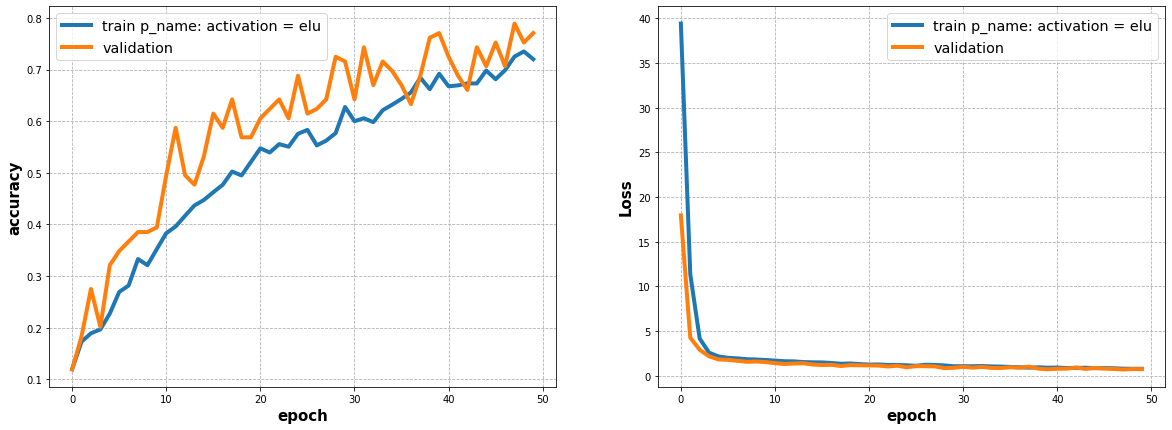

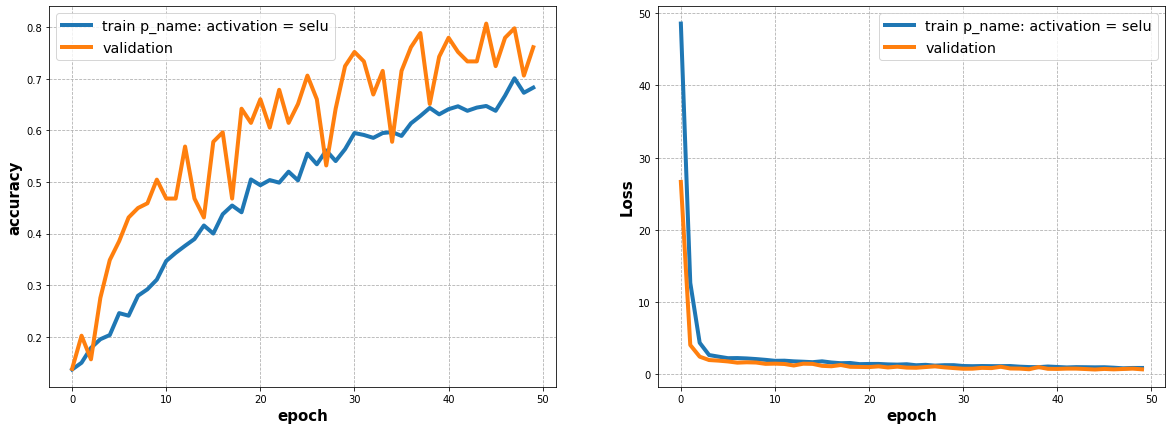

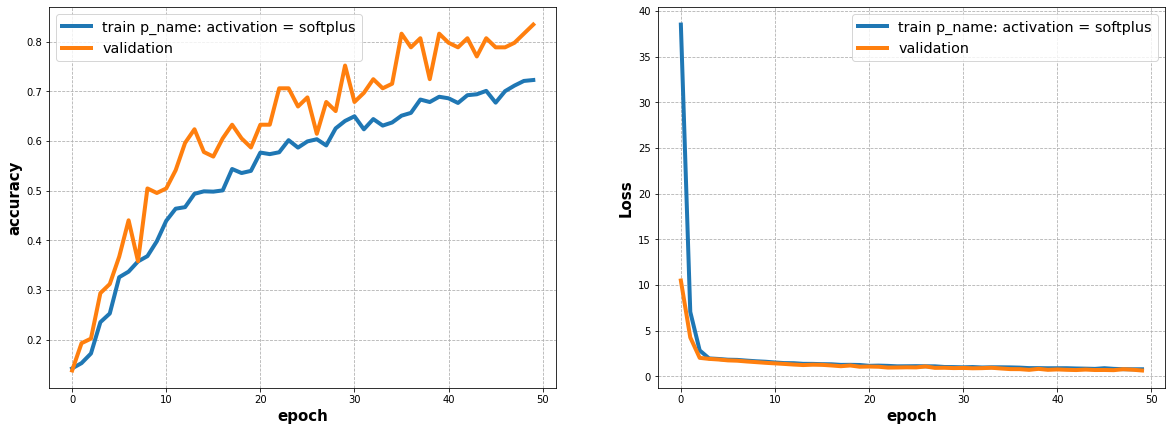

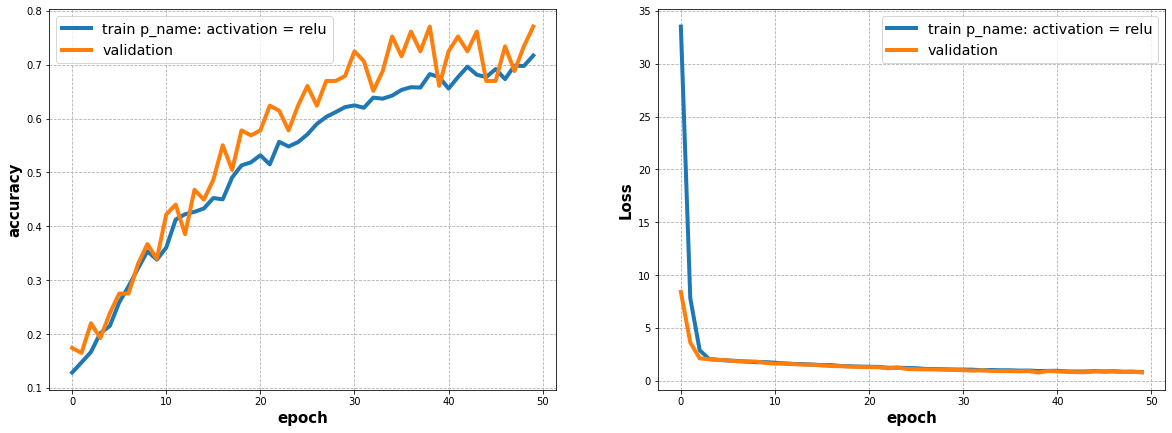

In [36]:
for value in activation:
  plot_metric(his[value], 'activation', value)

From above I can see that with Relu the model creates less overfitting

In [37]:

params['activation']='relu'

print("Hyperparameter:")
params


Hyperparameter:


{'activation': 'relu',
 'dropout_rate': 0.2,
 'learning_rate': 0.0005,
 'neurons_per_layer': 1024,
 'num_hidden_layers': 1,
 'optimizer': 'adam',
 'weights': 'glorot_normal'}

###3. Weights

In [38]:
params

{'activation': 'relu',
 'dropout_rate': 0.2,
 'learning_rate': 0.0005,
 'neurons_per_layer': 1024,
 'num_hidden_layers': 1,
 'optimizer': 'adam',
 'weights': 'glorot_normal'}

In [43]:
weights = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal',
          'glorot_uniform', 'he_normal', 'he_uniform']
acc, loss, his = check_parameter('weights', 
                                 weights, verbose=1, callbacks=0)


I am computing the parameter weights  for these values: ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
computing for value uniform:

accuracy: weights value uniform
0.7156
--------------------
computing for value lecun_uniform:

accuracy: weights value lecun_uniform
0.7523
--------------------
computing for value normal:

accuracy: weights value normal
0.8165
--------------------
computing for value zero:

accuracy: weights value zero
0.1376
--------------------
computing for value glorot_normal:

accuracy: weights value glorot_normal
0.7523
--------------------
computing for value glorot_uniform:

accuracy: weights value glorot_uniform
0.7064
--------------------
computing for value he_normal:

accuracy: weights value he_normal
0.7156
--------------------
computing for value he_uniform:

accuracy: weights value he_uniform
0.8257
--------------------
EXECUTION TIME: 27.448513746261597 seconds


I can exclude zero as inizialization

In [40]:
weights = ['uniform', 'lecun_uniform', 'normal', 'glorot_normal',
          'glorot_uniform', 'he_normal', 'he_uniform']
d_weight = optimal_hyperparameter('weights', weights, max_iterations=10 )


Epoch 00049: early stopping
Epoch 00010: early stopping
Epoch 00010: early stopping
Epoch 00018: early stopping
Epoch 00021: early stopping
Epoch 00016: early stopping
Epoch 00021: early stopping
Epoch 00025: early stopping
Epoch 00015: early stopping
Epoch 00014: early stopping
[0.752293586730957, 0.7981651425361633, 0.7339449524879456, 0.8440366983413696, 0.8073394298553467, 0.8440366983413696, 0.78899085521698, 0.8165137767791748, 0.8623853325843811, 0.8256880640983582]
{'uniform': 0.8073394536972046}
Epoch 00020: early stopping
Epoch 00017: early stopping
Epoch 00024: early stopping
Epoch 00011: early stopping
Epoch 00016: early stopping
Epoch 00016: early stopping
Epoch 00018: early stopping
Epoch 00013: early stopping
Epoch 00014: early stopping
[0.7614678740501404, 0.7614678740501404, 0.78899085521698, 0.8256880640983582, 0.8165137767791748, 0.78899085521698, 0.8348624110221863, 0.8623853325843811, 0.8165137767791748, 0.8807339668273926]
{'uniform': 0.8073394536972046, 'lecun_un

In [41]:
d_weight

{'glorot_normal': 0.7614678978919983,
 'glorot_uniform': 0.8055045962333679,
 'he_normal': 0.8385321080684662,
 'he_uniform': 0.8311926603317261,
 'lecun_uniform': 0.8137614786624908,
 'normal': 0.8146789073944092,
 'uniform': 0.8073394536972046}

Weights have similar values, so I plot and choose the best parameter

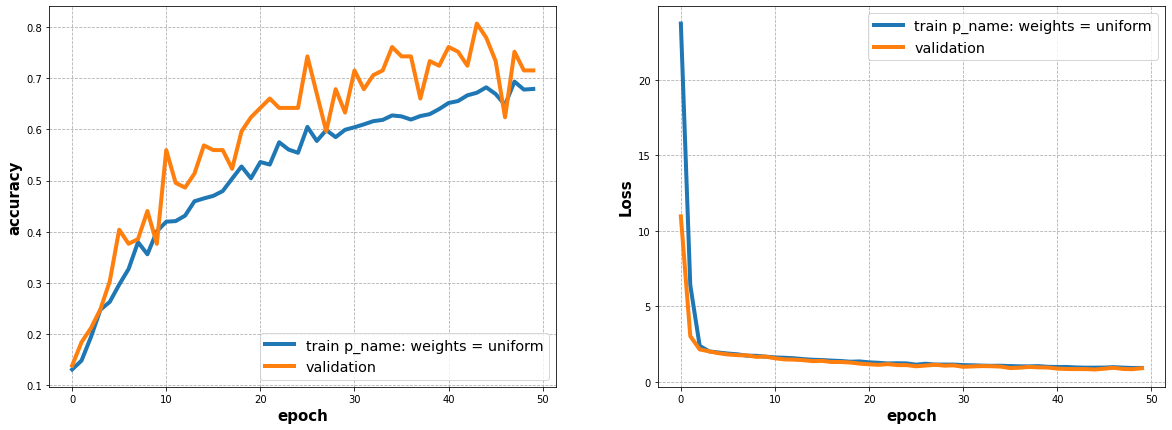

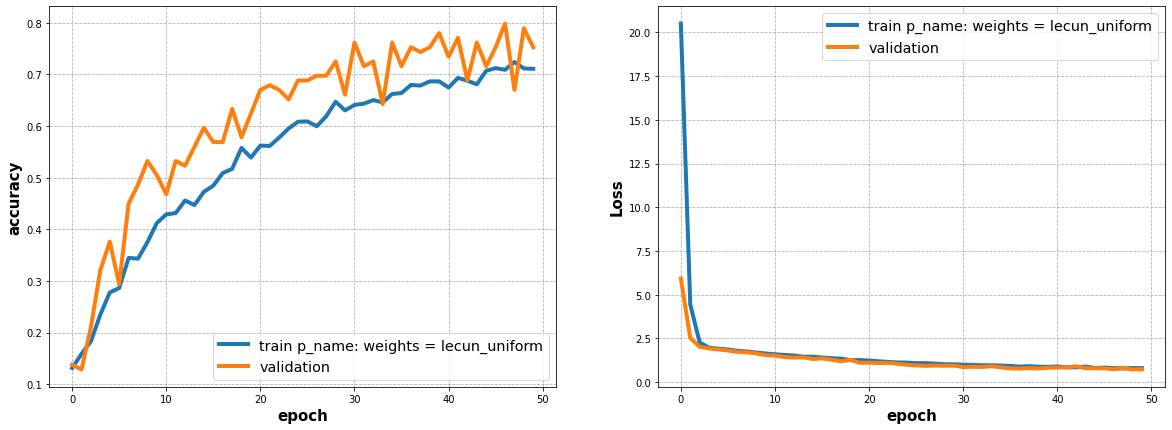

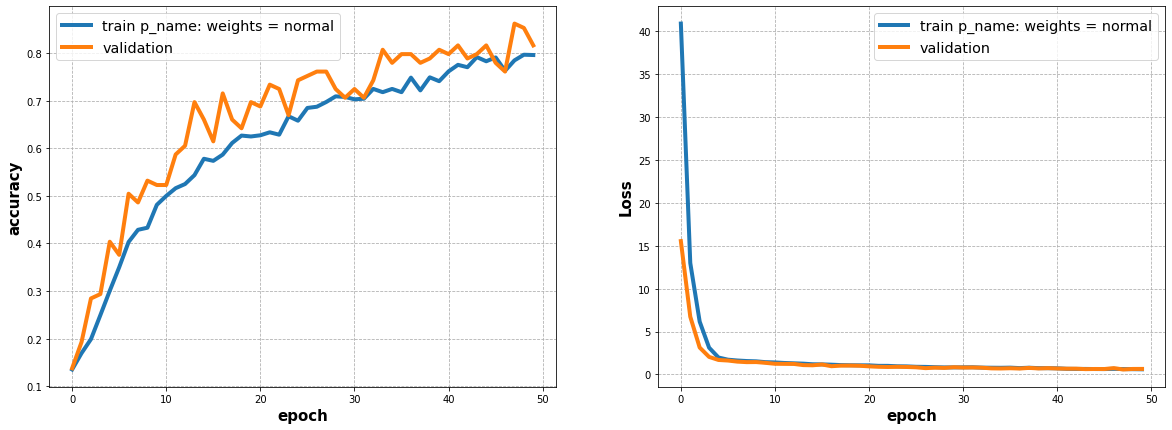

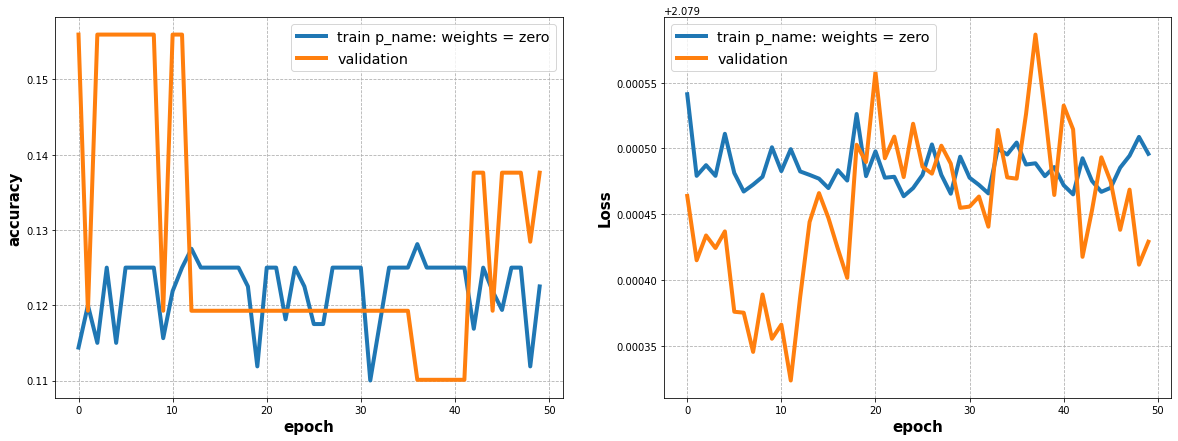

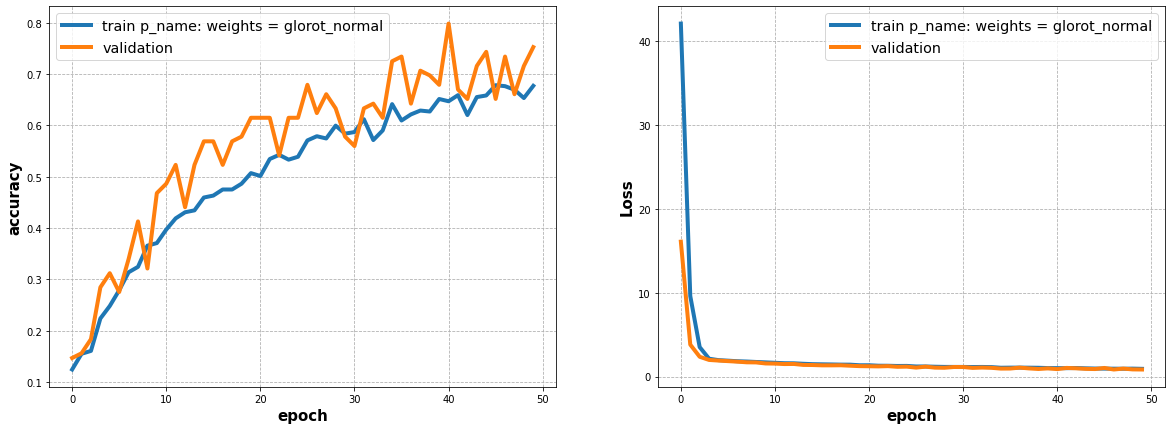

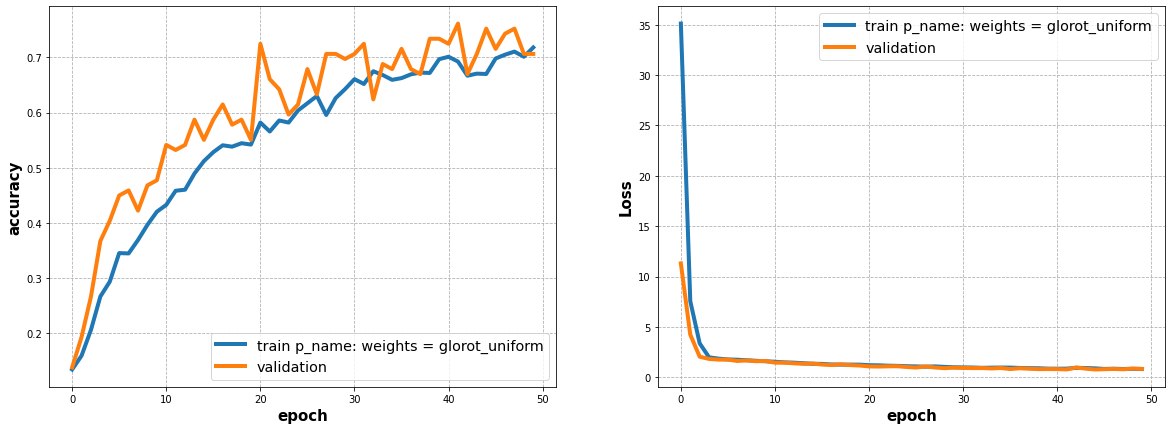

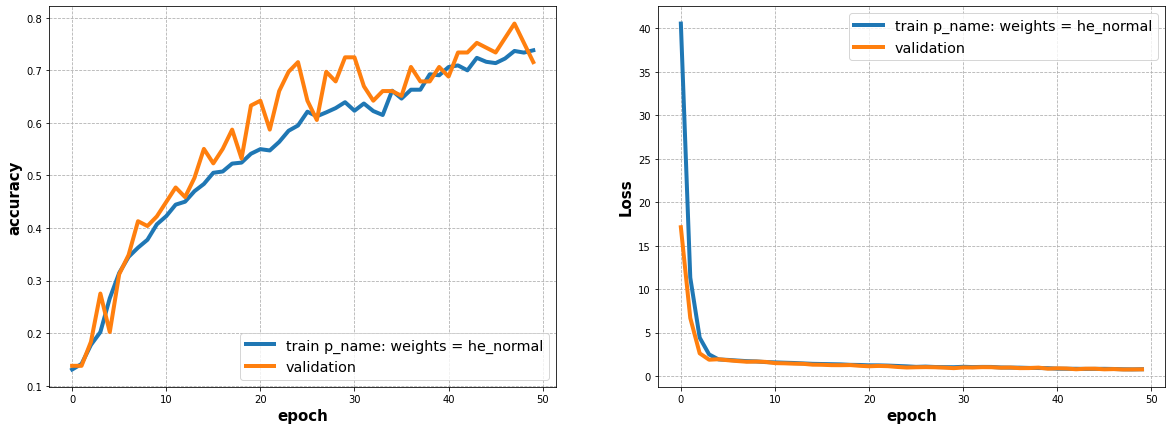

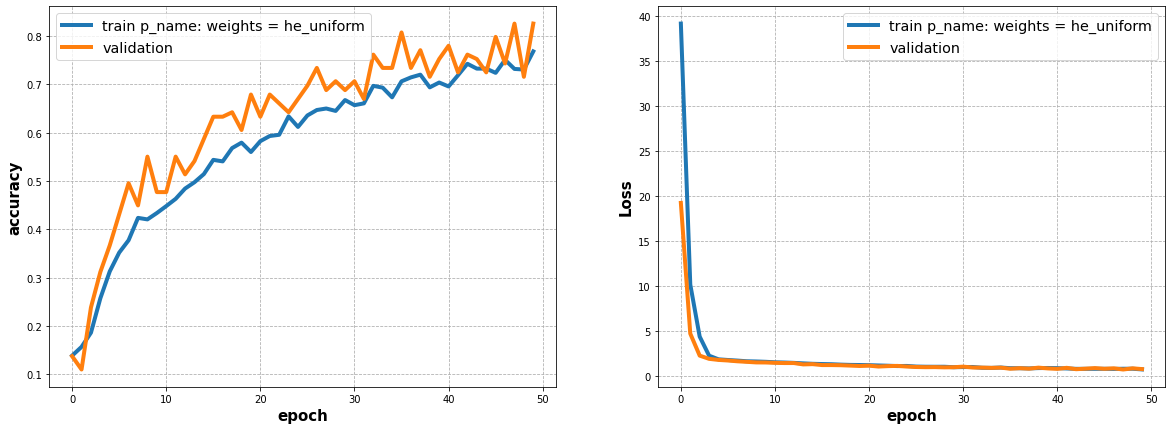

In [44]:
for value in weights:
  plot_metric(his[value], 'weights', value)

From above, the best paramter that preserves overfitting is `he_normal`

In [45]:
params['weights']='he_normal'
print("Hyperparameter:")
params

Hyperparameter:


{'activation': 'relu',
 'dropout_rate': 0.2,
 'learning_rate': 0.0005,
 'neurons_per_layer': 1024,
 'num_hidden_layers': 1,
 'optimizer': 'adam',
 'weights': 'he_normal'}

###4. Dropout

In [102]:
dropout = np.linspace(0,1,11)
dropout[:len(dropout)-1]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [46]:
dropout = np.linspace(0,1,11)
acc, loss, his = check_parameter('dropout_rate', 
                                 dropout[:len(dropout)-1], verbose=1, callbacks=0)

I am computing the parameter dropout_rate  for these values: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
computing for value 0.0:

accuracy: dropout_rate value 0.0
0.789
--------------------
computing for value 0.1:

accuracy: dropout_rate value 0.1
0.7982
--------------------
computing for value 0.2:

accuracy: dropout_rate value 0.2
0.7523
--------------------
computing for value 0.30000000000000004:

accuracy: dropout_rate value 0.30000000000000004
0.7339
--------------------
computing for value 0.4:

accuracy: dropout_rate value 0.4
0.6239
--------------------
computing for value 0.5:

accuracy: dropout_rate value 0.5
0.6972
--------------------
computing for value 0.6000000000000001:

accuracy: dropout_rate value 0.6000000000000001
0.4312
--------------------
computing for value 0.7000000000000001:

accuracy: dropout_rate value 0.7000000000000001
0.3853
--------------------
computing for value 0.8:

accuracy: dropout_rate value 0.8
0.1284
--------------------
computing for value 0.9

from above I can see that I can exclude dropout= 0.9, 0.8, 0.7

In [47]:
dropout = [0.1,0.2,0.3,0.4,0.5,0.6]
d_dropout = optimal_hyperparameter('dropout_rate', 
                                        dropout, max_iterations=5 )

Epoch 00044: early stopping
Epoch 00038: early stopping
Epoch 00017: early stopping
Epoch 00019: early stopping
Epoch 00016: early stopping
[0.7798165082931519, 0.8715596199035645, 0.853210985660553, 0.8715596199035645, 0.8623853325843811]
{0.1: 0.847706413269043}
Epoch 00049: early stopping
Epoch 00023: early stopping
Epoch 00016: early stopping
Epoch 00022: early stopping
Epoch 00014: early stopping
[0.8073394298553467, 0.7798165082931519, 0.853210985660553, 0.8623853325843811, 0.8348624110221863]
{0.1: 0.847706413269043, 0.2: 0.8275229334831238}
Epoch 00011: early stopping
Epoch 00026: early stopping
Epoch 00021: early stopping
Epoch 00012: early stopping
[0.7339449524879456, 0.7431192398071289, 0.7706422209739685, 0.7706422209739685, 0.7981651425361633]
{0.1: 0.847706413269043, 0.2: 0.8275229334831238, 0.3: 0.7633027553558349}
Epoch 00044: early stopping
Epoch 00021: early stopping
Epoch 00010: early stopping
Epoch 00016: early stopping
Epoch 00022: early stopping
[0.70642203092575

In [48]:
dropout = [0.1,0.2,0.3,0.4,0.5,0.6]
acc, loss, his = check_parameter('dropout_rate', dropout, 
                                  verbose=1, callbacks=0)

I am computing the parameter dropout_rate  for these values: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
computing for value 0.1:

accuracy: dropout_rate value 0.1
0.8073
--------------------
computing for value 0.2:

accuracy: dropout_rate value 0.2
0.7064
--------------------
computing for value 0.3:

accuracy: dropout_rate value 0.3
0.7339
--------------------
computing for value 0.4:

accuracy: dropout_rate value 0.4
0.6606
--------------------
computing for value 0.5:

accuracy: dropout_rate value 0.5
0.5229
--------------------
computing for value 0.6:

accuracy: dropout_rate value 0.6
0.6055
--------------------
EXECUTION TIME: 20.479463577270508 seconds


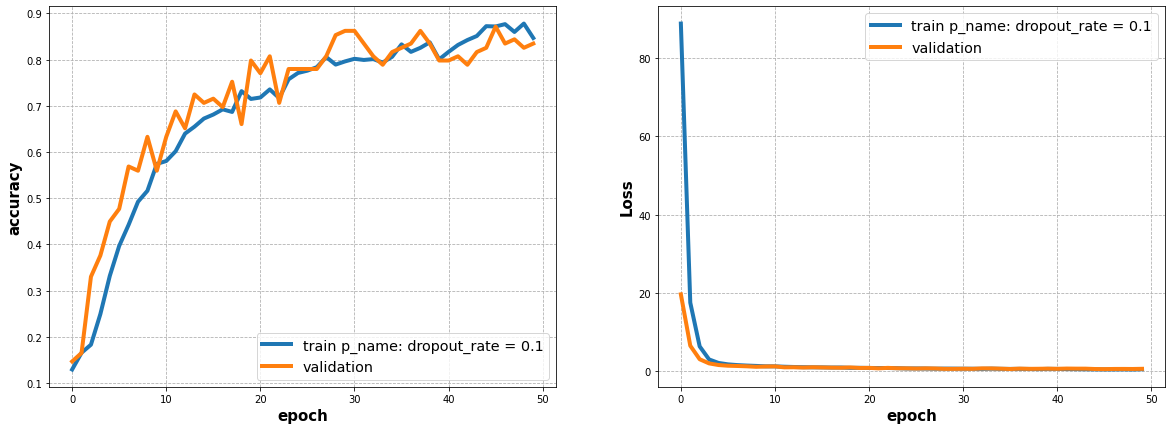

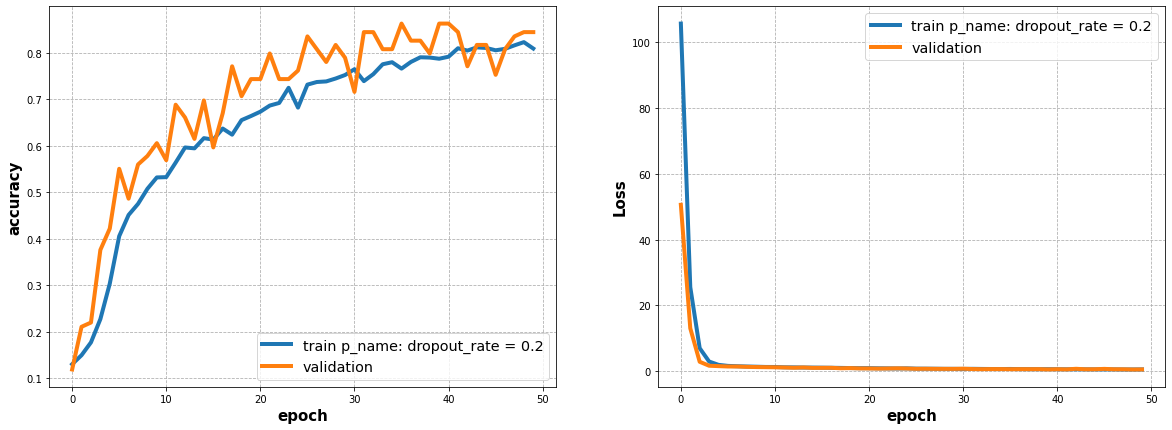

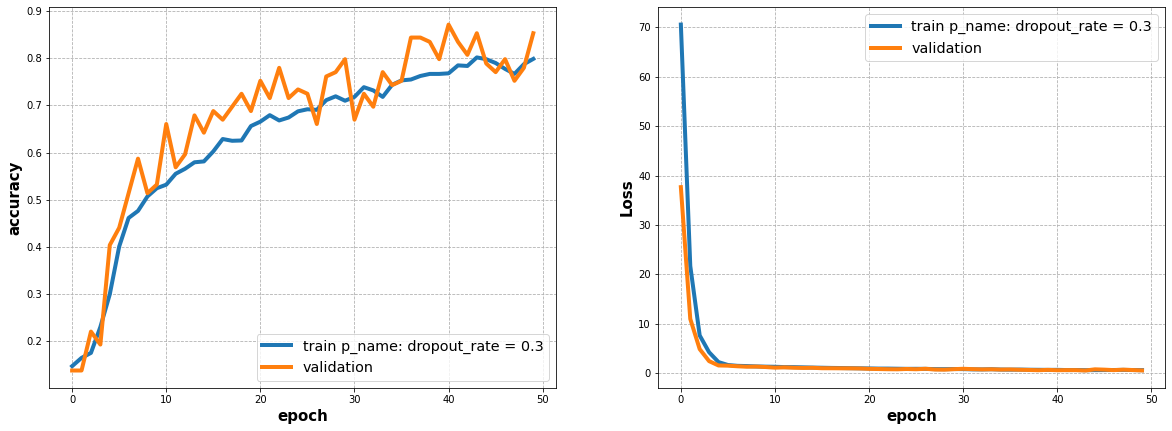

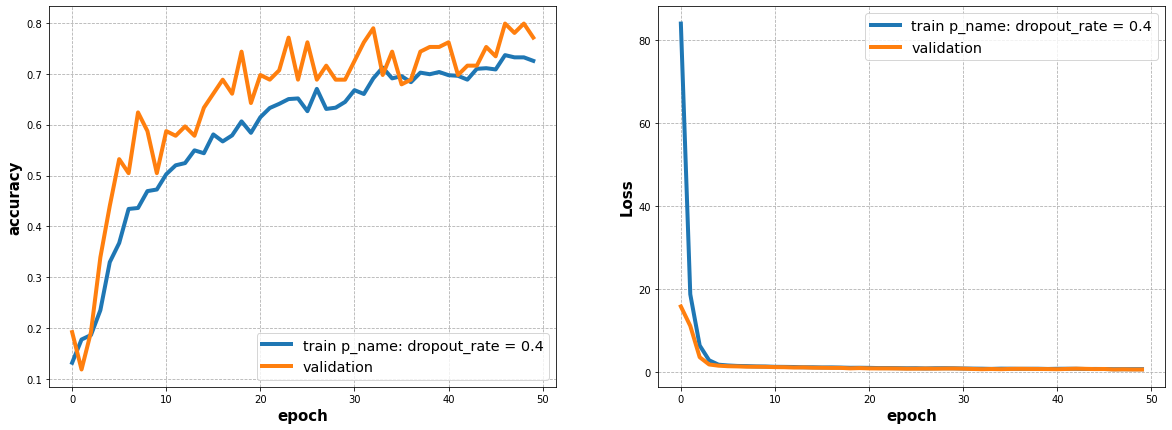

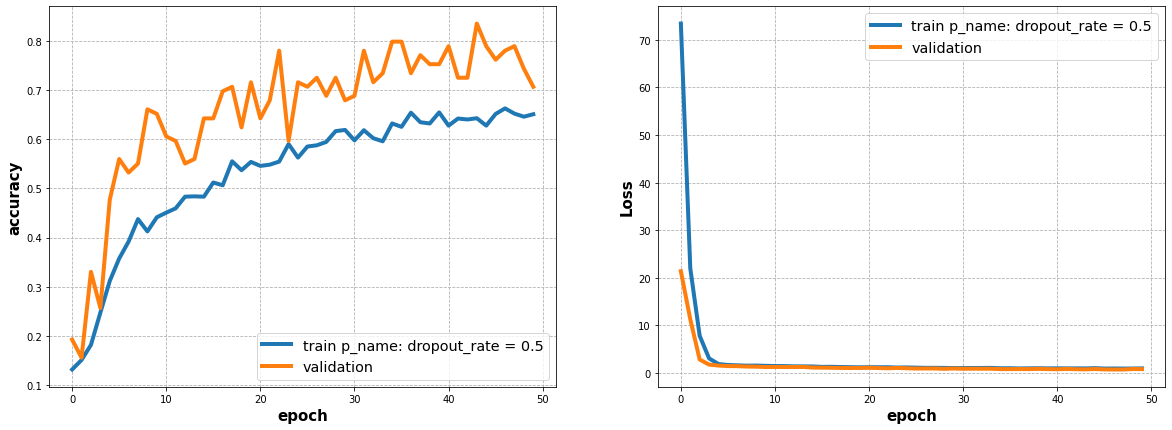

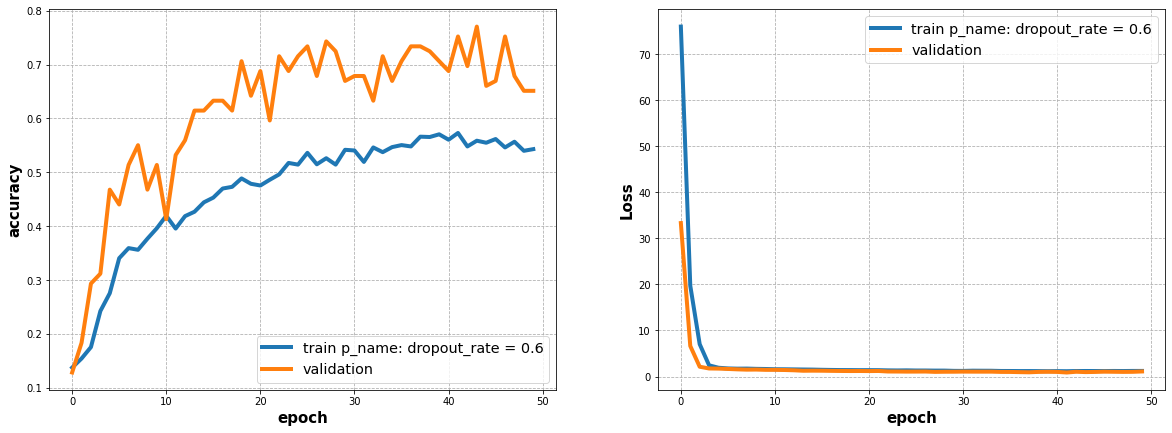

In [106]:
for value in dropout:
  plot_metric(his[value], 'dropout_rate', value)

In [49]:

best_value = max(d_dropout.values())
# print(d_dropout)
best_dropout=list(d_dropout.keys())[list(d_dropout.values()).index(best_value)]
params['dropout_rate']=best_dropout
print("Best dropout: " + str(best_dropout)+ " with value: "+
      str(best_value))
print("-"*30)
print("Hyperparameter:")
params

Best dropout: 0.1 with value: 0.847706413269043
------------------------------
Hyperparameter:


{'activation': 'relu',
 'dropout_rate': 0.1,
 'learning_rate': 0.0005,
 'neurons_per_layer': 1024,
 'num_hidden_layers': 1,
 'optimizer': 'adam',
 'weights': 'he_normal'}

###5. Learning rate

In [51]:
params

{'activation': 'relu',
 'dropout_rate': 0.1,
 'learning_rate': 0.0005,
 'neurons_per_layer': 1024,
 'num_hidden_layers': 1,
 'optimizer': 'adam',
 'weights': 'he_normal'}

I try with optimization algorithm SGD (stochastic gradient descent) and I try a range of Learning rate value

In [109]:
params['optimizer']='sgd'
print(params)
lr = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6]
acc, loss, his = check_parameter('learning_rate',lr, verbose=1, callbacks=1)


{'num_hidden_layers': 1, 'neurons_per_layer': 4096, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0005, 'weights': 'he_normal'}
I am computing the parameter learning_rate  for these values: [1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06]
computing for value 1.0:

Epoch 00014: early stopping
accuracy: learning_rate value 1.0
0.578
--------------------
computing for value 0.1:

Epoch 00041: early stopping
accuracy: learning_rate value 0.1
0.7706
--------------------
computing for value 0.01:

Epoch 00027: early stopping
accuracy: learning_rate value 0.01
0.6697
--------------------
computing for value 0.001:

Epoch 00027: early stopping
accuracy: learning_rate value 0.001
0.7064
--------------------
computing for value 0.0001:

Epoch 00041: early stopping
accuracy: learning_rate value 0.0001
0.7706
--------------------
computing for value 1e-05:

Epoch 00022: early stopping
accuracy: learning_rate value 1e-05
0.7615
--------------------
computing for val

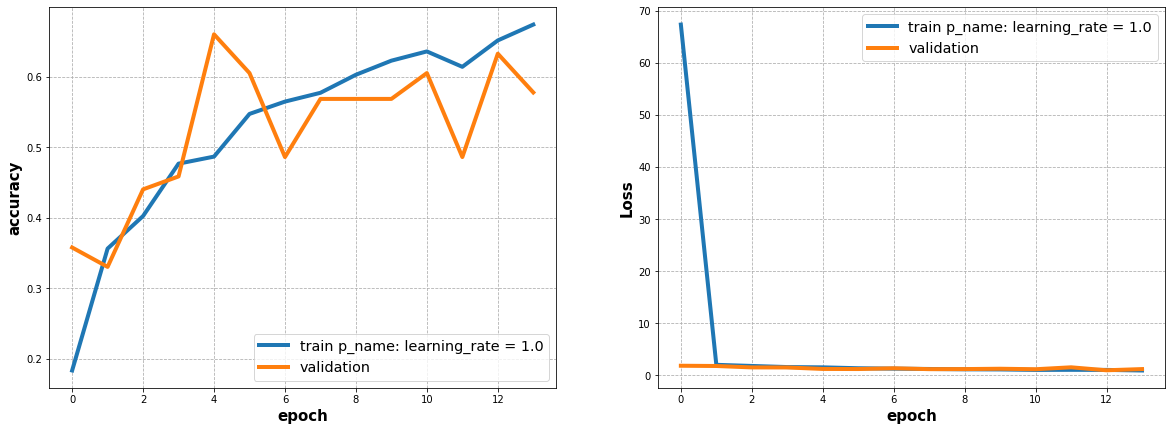

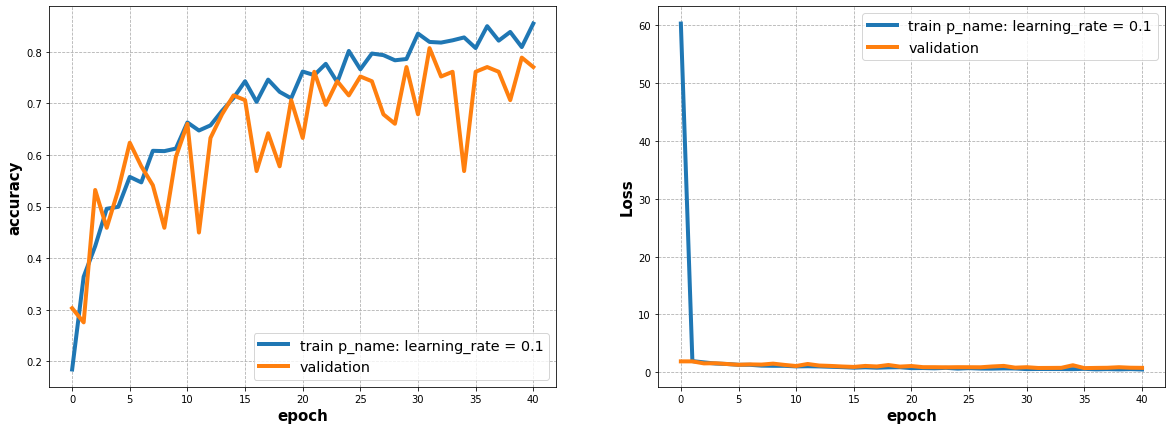

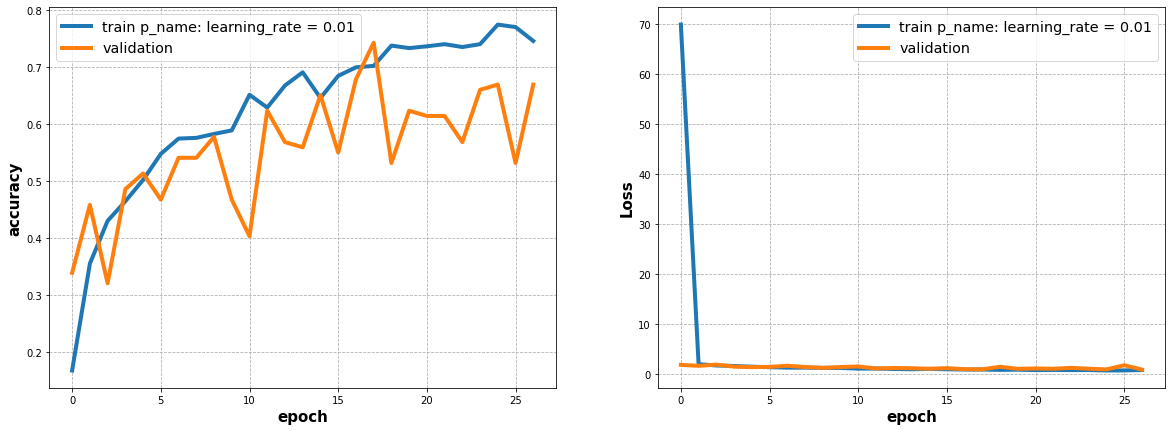

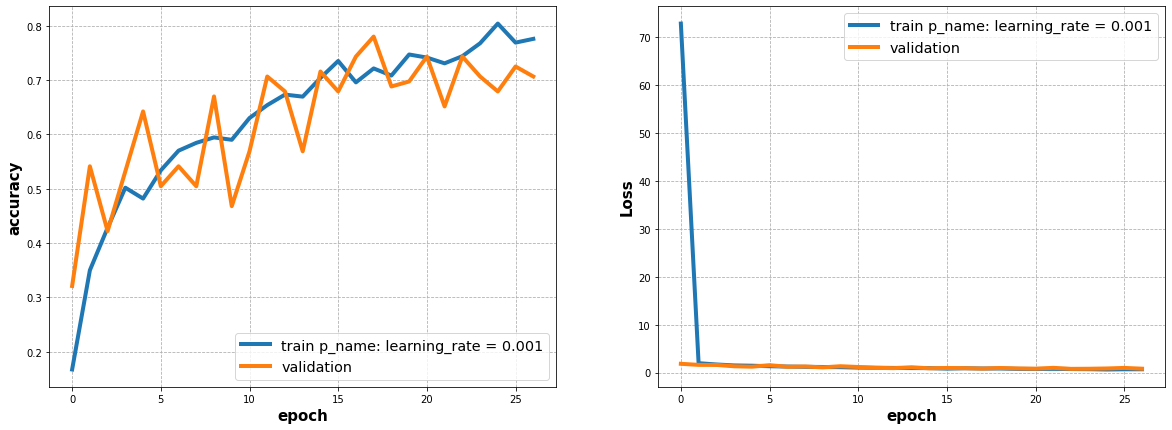

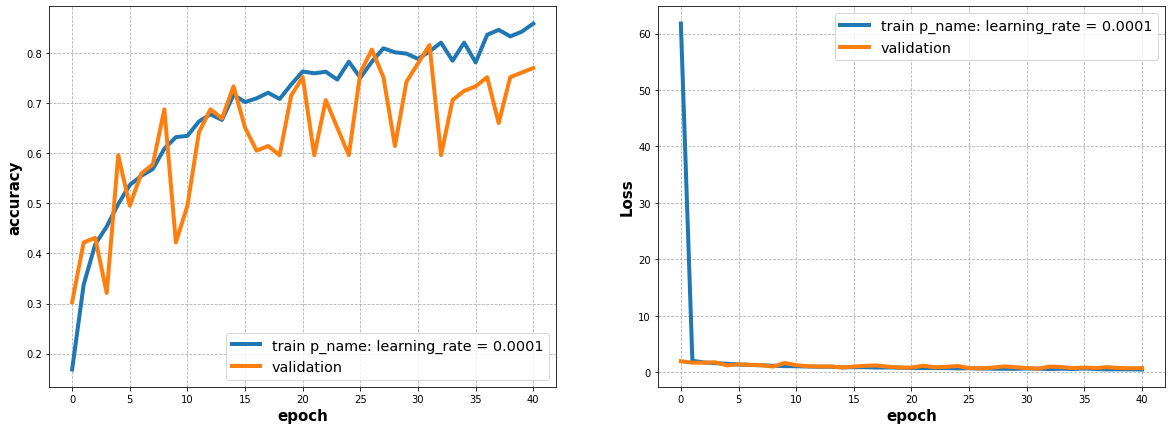

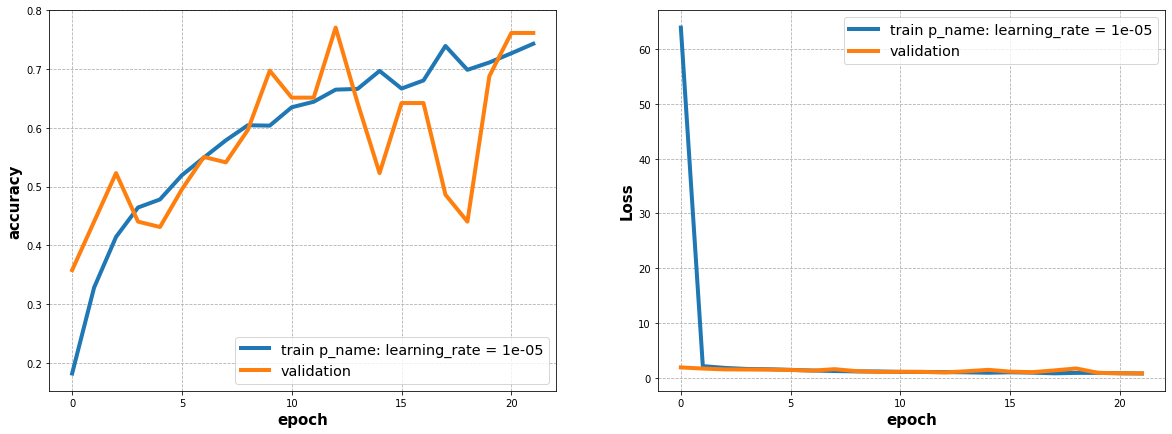

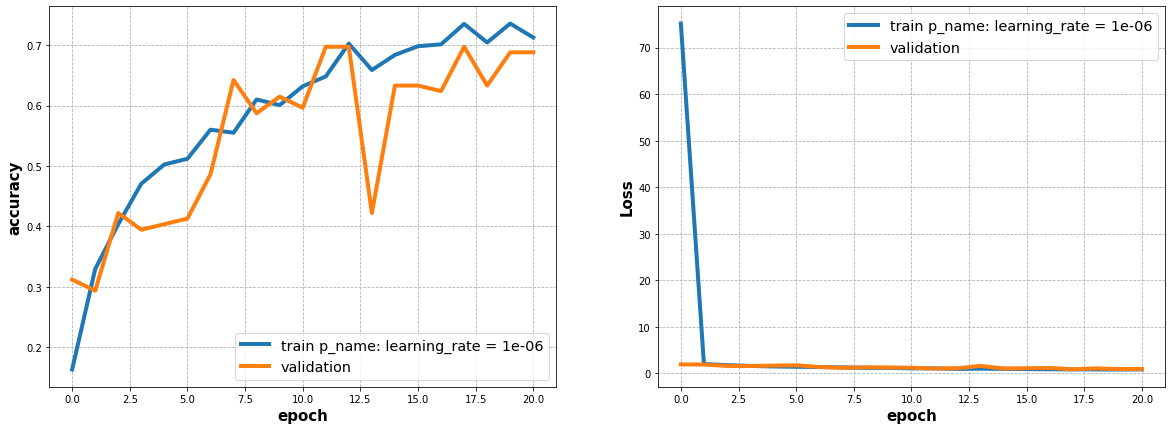

In [110]:
for value in lr:
  plot_metric(his[value], 'learning_rate', value)

With SGD I create to much variability in graph, So I try to change optimizer and then searching for learning rate

In [111]:
params['learning_rate'] = 5e-4 # reset to initial value
print(params)
opt = ['sgd', 'rmsprop', 'adagrad', 
       'adam', 'adadelta', 'adamax', 'nadam', 'ftrl']
acc, loss, his = check_parameter('optimizer', 
                                 opt, verbose=1, callbacks=0)

{'num_hidden_layers': 1, 'neurons_per_layer': 4096, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0005, 'weights': 'he_normal'}
I am computing the parameter optimizer  for these values: ['sgd', 'rmsprop', 'adagrad', 'adam', 'adadelta', 'adamax', 'nadam', 'ftrl']
computing for value sgd:

accuracy: optimizer value sgd
0.8165
--------------------
computing for value rmsprop:

accuracy: optimizer value rmsprop
0.5413
--------------------
computing for value adagrad:

accuracy: optimizer value adagrad
0.7615
--------------------
computing for value adam:

accuracy: optimizer value adam
0.789
--------------------
computing for value adadelta:

accuracy: optimizer value adadelta
0.1835
--------------------
computing for value adamax:

accuracy: optimizer value adamax
0.8257
--------------------
computing for value nadam:

accuracy: optimizer value nadam
0.6789
--------------------
computing for value ftrl:

accuracy: optimizer value ftrl
0.4862
-----------

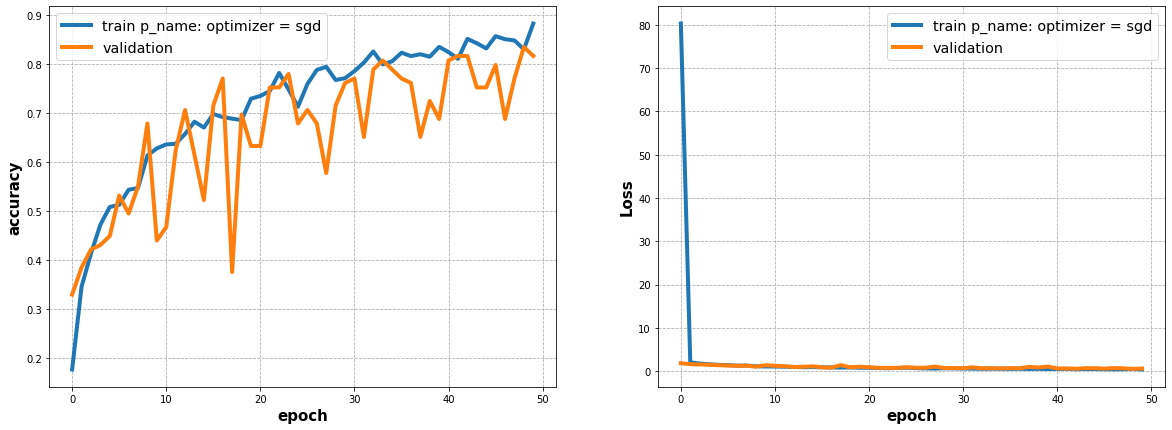

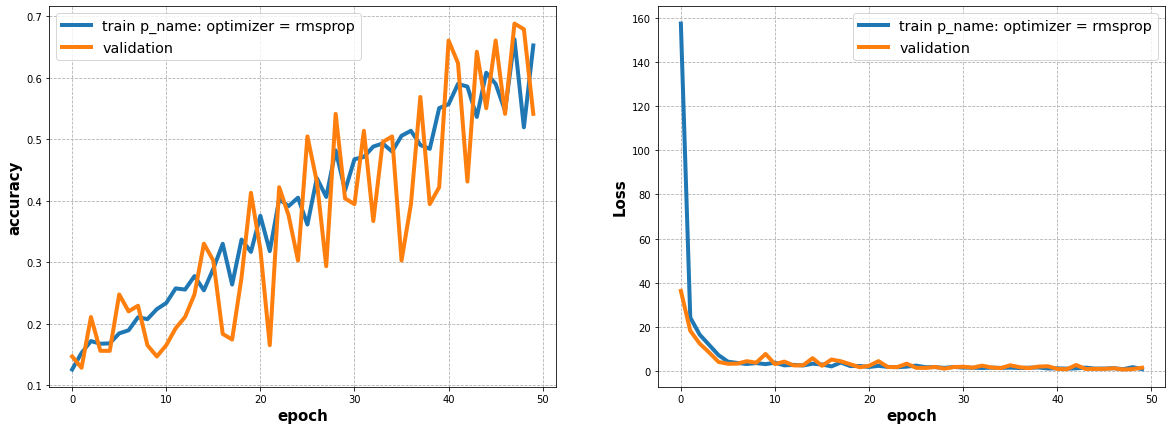

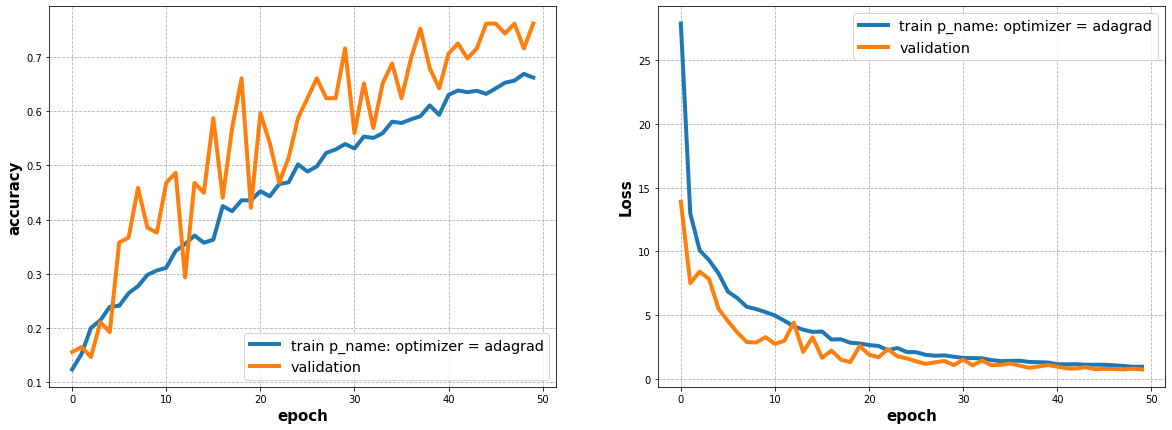

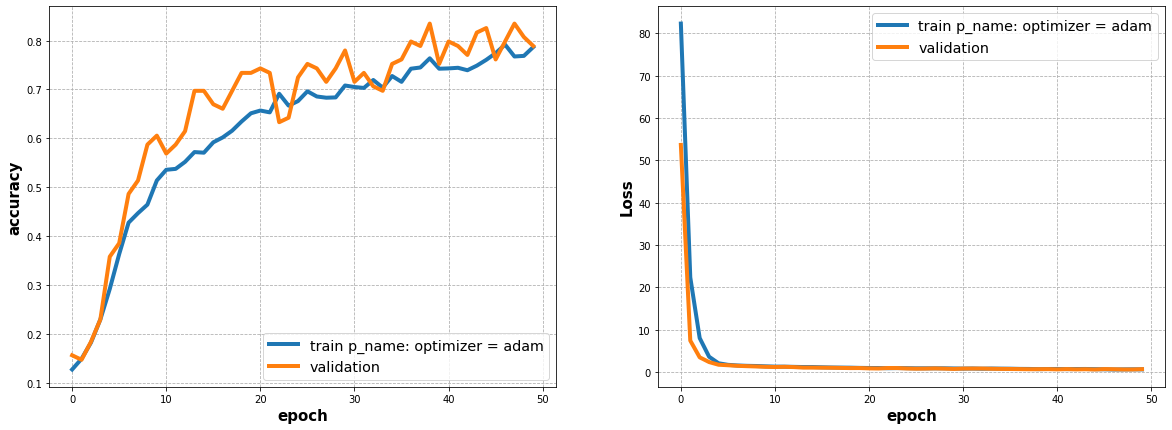

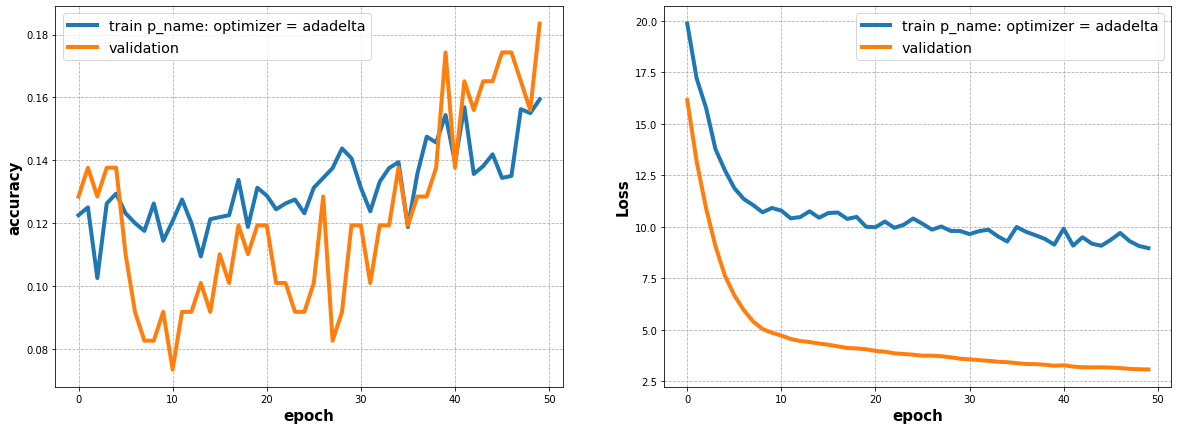

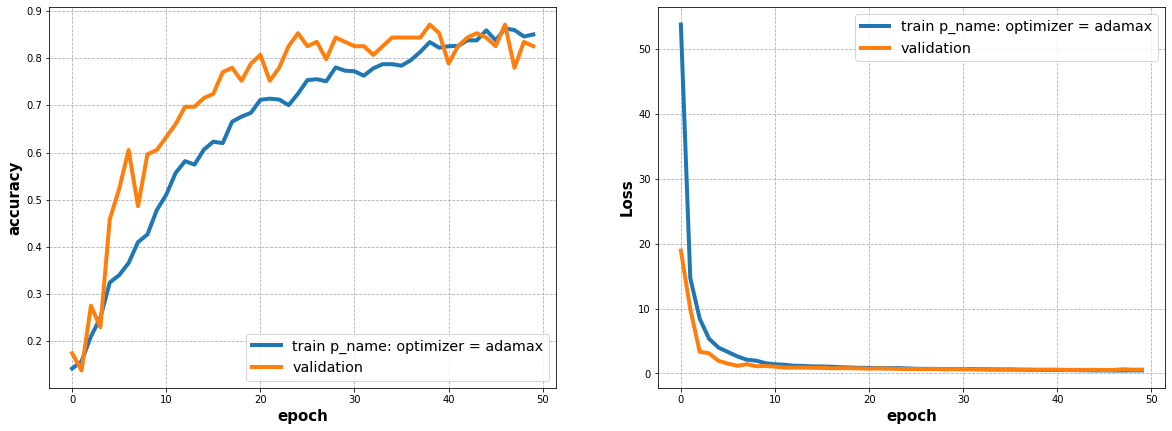

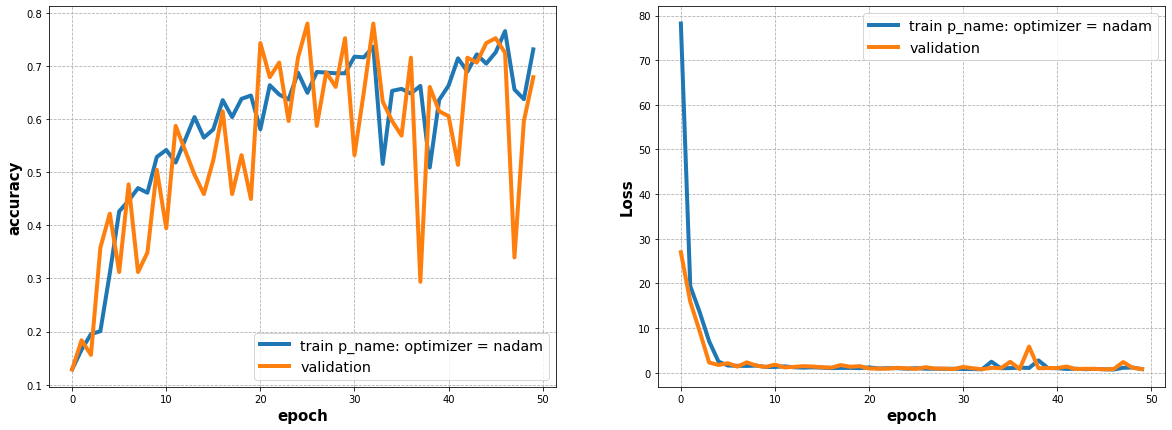

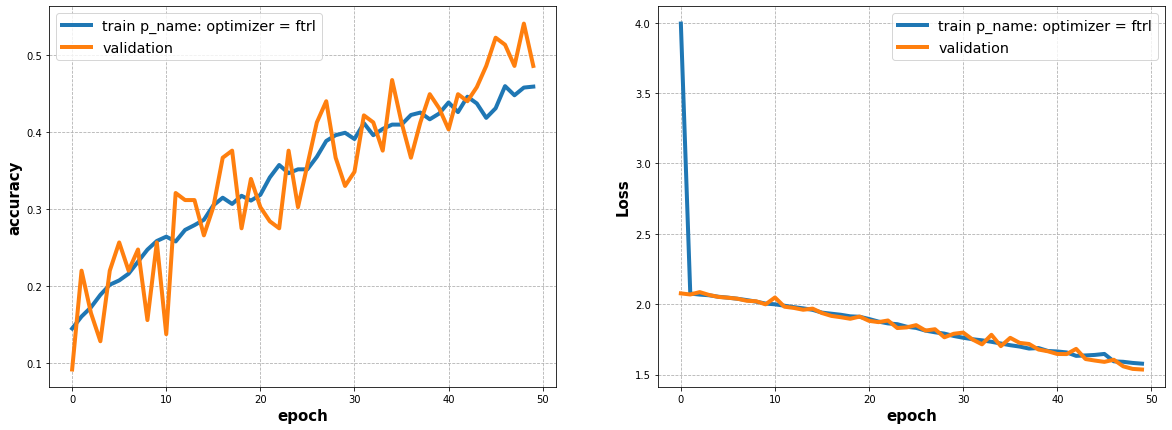

In [112]:
for value in opt:
  plot_metric(his[value], 'optimizer', value)

From cell above I can see that with optimizers `SGD`, `RMSProp`,`Adadelta`, `Nadam`, `Adagrad` and `Frtl` there is overfitting or too much variability, so I can exclude them

Now I try Learning with schedule using Adam as optimization algorithm

In [113]:
from keras.callbacks import LearningRateScheduler
import math

initial_learning_rate = 0.1
epochs = EPOCHS
def time_based_decay(epoch, lr):
    decay = initial_learning_rate / epochs
    return lr * 1 / (1 + decay * epoch)

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * math.pow(drop_rate, 
                                            math.floor(epoch/epochs_drop))

def lr_exp_decay(epoch, lr):
    k = 0.1
    return initial_learning_rate * math.exp(-k*epoch)






{'num_hidden_layers': 1, 'neurons_per_layer': 4096, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0005, 'weights': 'he_normal'}


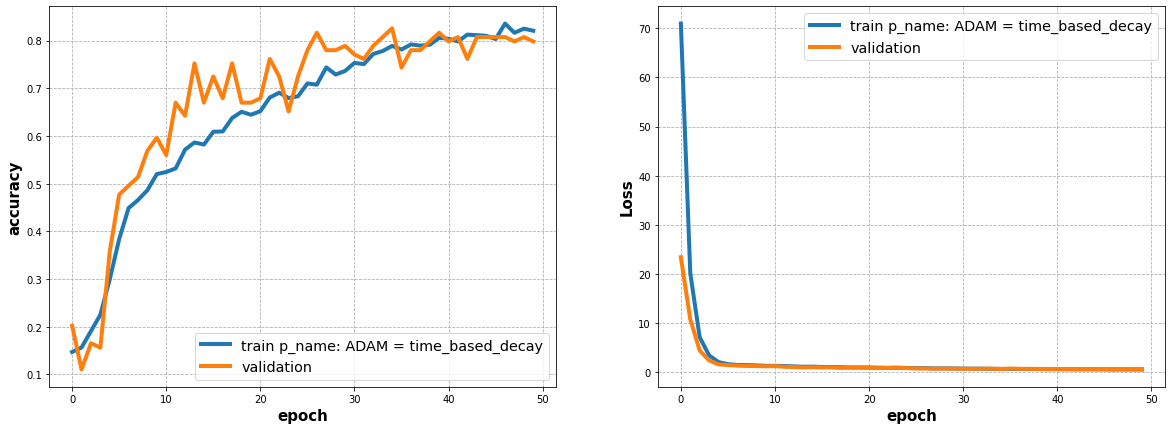

In [114]:
params['optimizer']='adam'
print(params)
m = create_model(params)
his = m.fit(x_train,y=y_train, 
            validation_data=(x_validation, y_validation), epochs=50 ,
            batch_size=128 ,
            callbacks=[LearningRateScheduler(time_based_decay, 
                                             verbose=0)], verbose=0)
plot_metric(his, 'ADAM', 'time_based_decay')

{'num_hidden_layers': 1, 'neurons_per_layer': 4096, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0005, 'weights': 'he_normal'}


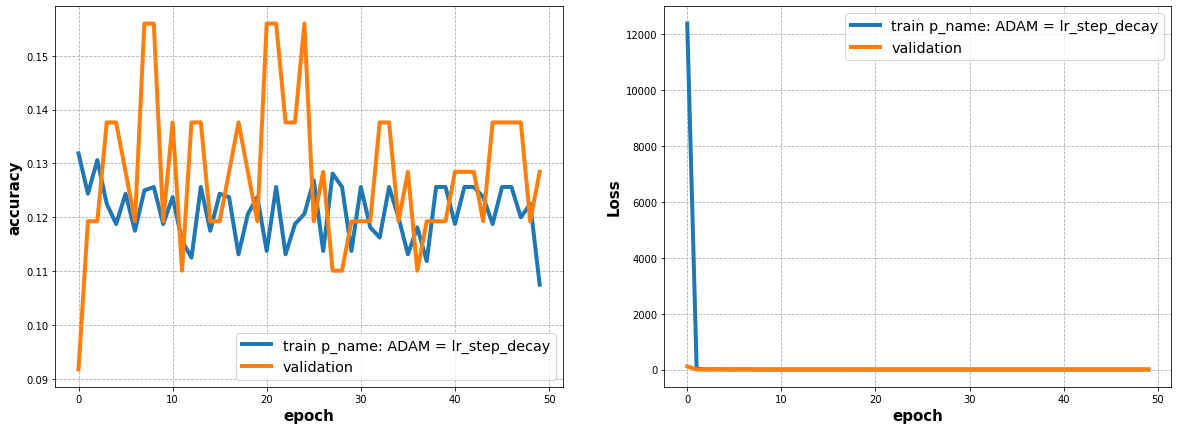

In [115]:
params['optimizer']='adam'
print(params)
m = create_model(params)
his = m.fit(x_train,y=y_train, 
            validation_data=(x_validation, y_validation), epochs=50 ,
            batch_size=128 ,
            callbacks=[LearningRateScheduler(lr_step_decay, 
                                             verbose=0)], verbose=0)
plot_metric(his, 'ADAM', 'lr_step_decay')

{'num_hidden_layers': 1, 'neurons_per_layer': 4096, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0005, 'weights': 'he_normal'}


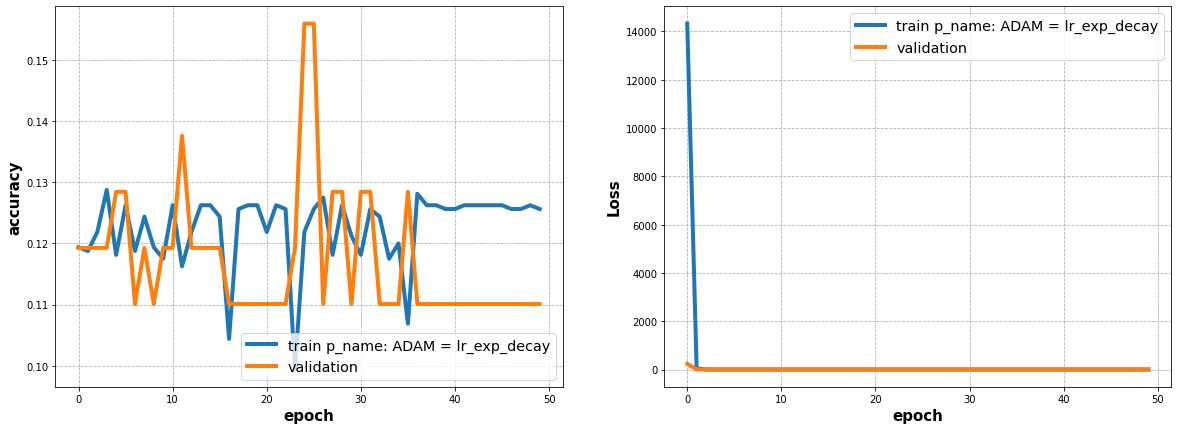

In [116]:
params['optimizer']='adam'
print(params)
m = create_model(params)
his = m.fit(x_train,y=y_train, 
            validation_data=(x_validation, y_validation), epochs=50 ,
            batch_size=128 ,
            callbacks=[LearningRateScheduler(lr_exp_decay, 
                                             verbose=0)], verbose=0)
plot_metric(his, 'ADAM', 'lr_exp_decay')

The best result is with the function `time_based_decay`.
Now I want to try another method to get learning rate parameter

 Now, I use class LRfinder (https://github.com/surmenok/keras_lr_finder/blob/master/keras_lr_finder/lr_finder.py), that gives the losses for each learning rate in a range

In [54]:
from lr_finder import *

In [55]:
start_lr = 0.000001
end_lr = 0.1
moving_average = 20

In [56]:
from keras.optimizers import *
def LR_range(tests, parameters):

  test_learning_rates = []
  test_losses = []
  test_loss_changes = []
  optimizers = []
  m =0
  for test_optimizer, opt in tests:
    # Compile the model
    parameters['optimizer']=opt
    print(parameters)
    m = create_model(parameters)
    lr_finder = LRFinder(m)
    # Perform the Learning Rate Range Test
    outputs = lr_finder.find(x_train, y_train, start_lr=start_lr, 
                          end_lr=end_lr, batch_size=128, epochs=50, verbose=0)
    # Get values
    learning_rates  = lr_finder.lrs
    losses          = lr_finder.losses
    loss_changes = []

    # Compute smoothed loss changes
    for i in range(moving_average, len(learning_rates)):
      loss_changes.append((losses[i] - losses[i - moving_average]) / moving_average)

    test_learning_rates.append(learning_rates)
    test_losses.append(losses)
    test_loss_changes.append(loss_changes)
    optimizers.append(opt)
  
  return test_learning_rates, test_losses




In [122]:
tests = [
  (Adam(), 'Adam'),
  (Adagrad(), 'Adagrad'), 
  (Adamax(), 'Adamax'),
  (Nadam(), 'Nadam'),
  (Ftrl(), 'Ftrl')]
test_learning_rates, test_losses=LR_range(tests, params)


{'num_hidden_layers': 1, 'neurons_per_layer': 4096, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.0005, 'weights': 'he_normal'}
{'num_hidden_layers': 1, 'neurons_per_layer': 4096, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'Adagrad', 'learning_rate': 0.0005, 'weights': 'he_normal'}
{'num_hidden_layers': 1, 'neurons_per_layer': 4096, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'Adamax', 'learning_rate': 0.0005, 'weights': 'he_normal'}
{'num_hidden_layers': 1, 'neurons_per_layer': 4096, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'Nadam', 'learning_rate': 0.0005, 'weights': 'he_normal'}
{'num_hidden_layers': 1, 'neurons_per_layer': 4096, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'Ftrl', 'learning_rate': 0.0005, 'weights': 'he_normal'}


In [123]:
def plot_loss_lr(test_learning_rates, test_losses, optimizers, diff_print=False):
  plt.figure(figsize=(20,7))
  print(len(test_learning_rates))
  print(test_learning_rates)
  print()
  print(test_losses)
  if diff_print:
    plt.subplot(2,1,1)
    for i in range(0, len(test_learning_rates[:3])):
      plt.plot(test_learning_rates[i], test_losses[i], label=optimizers[i])
    plt.xscale('log')
    plt.legend(loc='upper left')
    plt.ylabel('loss')
    plt.xlabel('learning rate (log scale)')
    plt.title('Results for Learning Rate Range Test / Loss Values for Learning Rate')


    plt.subplot(2,1,2)
    for i in range(3, len(test_learning_rates)):
      plt.plot(test_learning_rates[i], test_losses[i], label=optimizers[i])
    plt.xscale('log')
    plt.legend(loc='upper left')
    plt.ylabel('loss')
    plt.xlabel('learning rate (log scale)')
    plt.title('Results for Learning Rate Range Test / Loss Values for Learning Rate')
    plt.show()
  else:
    for i in range(0, len(test_learning_rates)):
      plt.plot(test_learning_rates[i], test_losses[i], label=optimizers[i])
    plt.xscale('log')
    plt.legend(loc='upper left')
    plt.ylabel('loss')
    plt.xlabel('learning rate (log scale)')
    plt.title('Results for Learning Rate Range Test / Loss Values for Learning Rate')
    plt.grid(True)
    plt.show()


5
[[1e-06, 1.0185914e-06, 1.0375285e-06, 1.0568176e-06, 1.0764653e-06, 1.0964783e-06, 1.1168634e-06, 1.1376274e-06, 1.1587774e-06, 1.1803207e-06, 1.2022646e-06, 1.2246163e-06, 1.2473836e-06, 1.2705742e-06, 1.294196e-06, 1.3182569e-06, 1.3427651e-06, 1.367729e-06, 1.393157e-06, 1.4190578e-06, 1.44544e-06, 1.4723128e-06, 1.4996851e-06, 1.5275664e-06, 1.5559659e-06, 1.5848935e-06, 1.6143589e-06, 1.6443721e-06, 1.6749433e-06, 1.7060828e-06, 1.7378012e-06, 1.7701093e-06, 1.8030181e-06, 1.8365387e-06, 1.8706825e-06, 1.9054611e-06, 1.9408862e-06, 1.97697e-06, 2.0137247e-06, 2.0511627e-06, 2.0892967e-06, 2.1281396e-06, 2.1677047e-06, 2.2080053e-06, 2.2490551e-06, 2.2908682e-06, 2.3334587e-06, 2.376841e-06, 2.4210296e-06, 2.4660399e-06, 2.511887e-06, 2.5585864e-06, 2.606154e-06, 2.654606e-06, 2.703959e-06, 2.7542292e-06, 2.8054342e-06, 2.8575912e-06, 2.9107177e-06, 2.964832e-06, 3.0199524e-06, 3.0760975e-06, 3.1332866e-06, 3.1915388e-06, 3.250874e-06, 3.3113122e-06, 3.372874e-06, 3.4355805e-06,

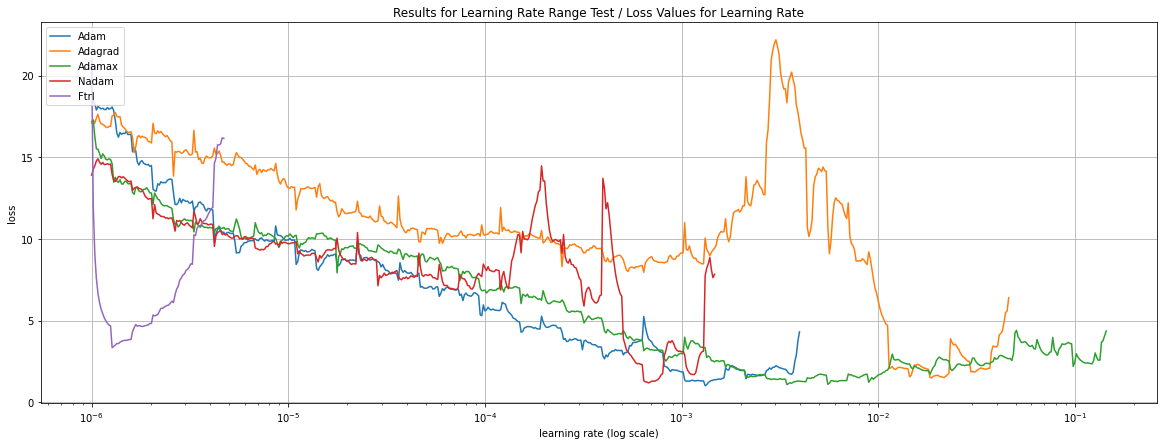

In [124]:
optimizers =[opt[1] for opt in tests]
plot_loss_lr(test_learning_rates, test_losses, optimizers)

I can exclude from above: `Ftrl`, `Nadam`, `Adagrad` and I can consider the min loss for optimizer `Adam` and `Adamax`

In [57]:
tests = [
  (Adam(), 'Adam'),
  (Adamax(), 'Adamax')]
test_learning_rates, test_losses=LR_range(tests, params)

min_lr = {}
i=0
for loss in test_losses:
  print(loss)
  best = min(loss)
  ind = loss.index(best)
  print("best " + str(best))
  print("ind " + str(ind))
  min_lr[tests[i][1]]=test_learning_rates[i][ind]
  print(tests[i][1])
  print(min_lr)
  i += 1
min_lr

{'num_hidden_layers': 1, 'neurons_per_layer': 1024, 'dropout_rate': 0.1, 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.0005, 'weights': 'he_normal'}
{'num_hidden_layers': 1, 'neurons_per_layer': 1024, 'dropout_rate': 0.1, 'activation': 'relu', 'optimizer': 'Adamax', 'learning_rate': 0.0005, 'weights': 'he_normal'}
[10.996418952941895, 11.225469589233398, 11.496758460998535, 11.17812728881836, 11.131640434265137, 10.88305377960205, 10.85859489440918, 10.852354049682617, 10.833831787109375, 10.72968864440918, 10.588035583496094, 10.4708251953125, 10.49159049987793, 10.056714057922363, 10.155460357666016, 10.218616485595703, 10.454803466796875, 10.216947555541992, 10.012511253356934, 9.96413516998291, 9.910101890563965, 9.799955368041992, 9.864038467407227, 9.804043769836426, 9.709272384643555, 9.646167755126953, 8.95817756652832, 9.152948379516602, 9.073716163635254, 8.830607414245605, 8.589863777160645, 8.513065338134766, 8.572380065917969, 8.687746047973633, 8.659721374

{'Adam': 0.0008953647, 'Adamax': 0.004365159}

{'num_hidden_layers': 1, 'neurons_per_layer': 1024, 'dropout_rate': 0.1, 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.0008953647, 'weights': 'he_normal'}
OPTIMIZER Adam
accuracy: 0.771----loss: 0.717
--------------------


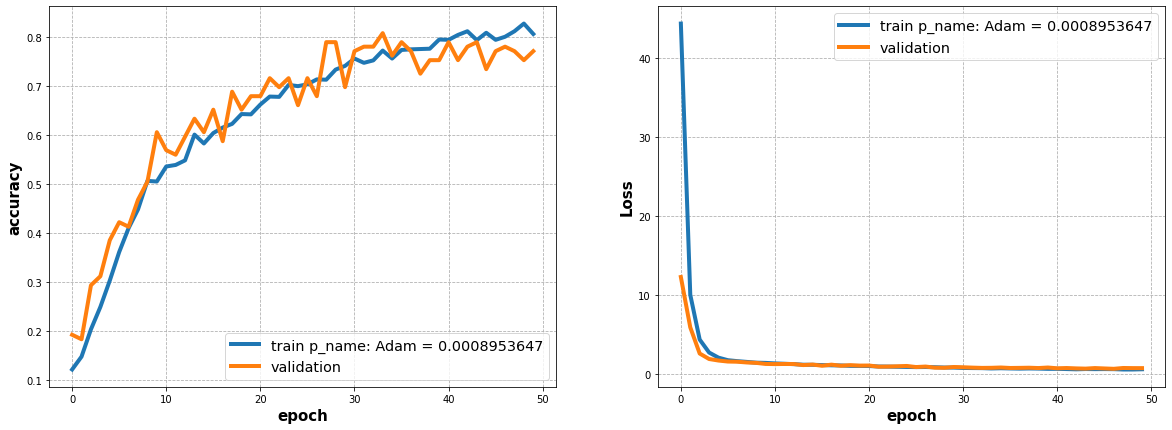

{'num_hidden_layers': 1, 'neurons_per_layer': 1024, 'dropout_rate': 0.1, 'activation': 'relu', 'optimizer': 'Adamax', 'learning_rate': 0.004365159, 'weights': 'he_normal'}
OPTIMIZER Adamax
accuracy: 0.78----loss: 0.784
--------------------


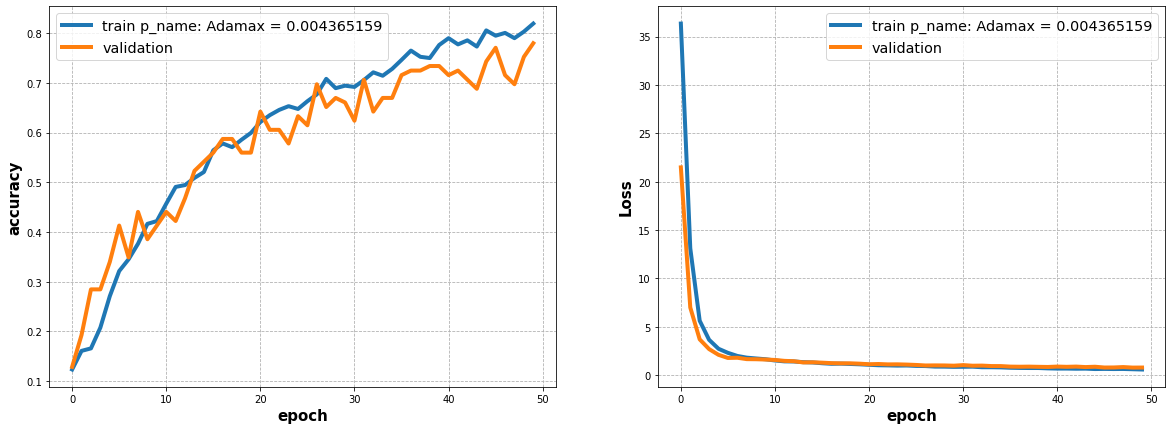

In [58]:
opt_history={}
for method in min_lr.keys():

  params['optimizer'] = method
  params['learning_rate'] = min_lr[method]
  print(params)
  m = create_model(params)
  his = m.fit(x_train,y=y_train, 
                validation_data=(x_validation, y_validation), epochs=50 ,
                batch_size=128 ,verbose =0)
  opt_history[method] = his
  predictions = m.predict(x_validation)
  y_pred = np.argmax(predictions, axis = 1)
  metrics = m.evaluate(x_validation, y_validation, verbose=0)
  print("OPTIMIZER " + method)
  print("accuracy: " + str(round(metrics[1],3)) + 
        "----loss: " + str(round(metrics[0],3)))
  print('-'*20)
  plot_metric(his,p_name=method, p_value=min_lr[method])

`Adam` and `Adamax` are very similar, I try a configuration with both

Adamax shows less variability, so I choose it as final hyperparameter

In [67]:
print("FINAL HYPERPARAMETER")
params['optimizer']='Adam'
params['learning_rate']=0.0008953647
params

FINAL HYPERPARAMETER


{'activation': 'relu',
 'dropout_rate': 0.1,
 'learning_rate': 0.0008953647,
 'neurons_per_layer': 1024,
 'num_hidden_layers': 1,
 'optimizer': 'Adam',
 'weights': 'he_normal'}

* Activation: `Relu`
* Dropout: `0.1`
* Learning rate:` 0.0008953647`
* Neurons: `4096`
* Hidden Layers: `1`
* Optimizer: `Adam`
* Weight: `He_normal`

# Evaluation

In [68]:
##################################################
# Evaluate the model here
##################################################

# Use this function to evaluate your model
def accuracy(y_pred, y_true):
    '''
    input y_pred: ndarray of shape (N,)
    input y_true: ndarray of shape (N,)
    '''
    return (1.0 * (y_pred == y_true)).mean()



# Send the submission for the challenge

In [69]:
##################################################
# Save your test prediction in y_test_pred
##################################################


# Create submission
submission = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'sample_submission.csv'))


### Preparing x_test

In [70]:
x_test_raw = np.load(os.path.join(DATA_BASE_FOLDER, 'test_feat.npy'))
x_test = []
for x_i in x_test_raw:
    x_test += [cv2.resize(x_i, (32, 32))]
print(len(x_test))
x_test = np.array(x_test)
print(x_test.shape)
x_test = x_test.reshape(x_test.shape[0], -1)

print(f'Features dimension size: {x_test.shape[-1]}')
print()
print(x_test.shape)
print(type(x_test))

136
(136, 32, 32)
Features dimension size: 1024

(136, 1024)
<class 'numpy.ndarray'>


### Preparing y_test from file `sample_submission.csv`

In [71]:
list(submission['word'])
y_test = submission['word'].map(lambda w: labels.index(w)).values
y_test


array([7, 3, 6, 5, 4, 4, 0, 1, 7, 1, 7, 1, 2, 6, 3, 6, 4, 4, 2, 6, 2, 0,
       0, 4, 5, 0, 1, 7, 6, 6, 7, 2, 0, 3, 4, 5, 2, 6, 2, 3, 7, 3, 0, 1,
       3, 0, 3, 2, 3, 4, 1, 3, 3, 3, 2, 1, 6, 3, 7, 4, 2, 3, 6, 4, 1, 7,
       5, 4, 0, 4, 5, 5, 1, 7, 5, 7, 1, 4, 1, 4, 5, 0, 1, 0, 0, 4, 6, 0,
       6, 4, 2, 3, 7, 1, 2, 5, 6, 2, 5, 5, 6, 7, 4, 3, 5, 6, 7, 6, 4, 6,
       7, 7, 2, 2, 4, 4, 2, 7, 1, 7, 3, 6, 7, 2, 1, 6, 7, 4, 1, 0, 1, 2,
       1, 2, 1, 2])

### Predictions

In [77]:
print(params)
m = create_model(params)
print(m.summary())
his = m.fit(x_test, y_test,
            epochs=100,batch_size=64 ,verbose =0)
predictions = m.predict(x_test)
y_pred = np.argmax(predictions, axis = 1)
y_pred 
# accuracy(y_pred, y_test)
acc, loss = m.evaluate(x_test, y_test)

{'num_hidden_layers': 1, 'neurons_per_layer': 1024, 'dropout_rate': 0.1, 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.0008953647, 'weights': 'he_normal'}
Model: "sequential_117"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_204 (Dropout)        (None, 1024)              0         
_________________________________________________________________
Output_layer (Dense)         (None, 8)                 8200      
Total params: 1,057,800
Trainable params: 1,057,800
Non-trainable params: 0
_________________________________________________________________
None
5/5 [==============================] - 0s 3ms/step - loss: 0.5826 - accuracy: 0.8897


### Final submission

In [78]:
y_test_pred = y_pred


if y_test_pred is not None:
    submission['class'] = [labels[int(y_i)] for y_i in y_test_pred]
submission.to_csv('my_submission.csv', index=False)

# Keras Tuner

In [ ]:
!pip install keras-tuner


In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner import HyperModel
from kerastuner import RandomSearch
from kerastuner import BayesianOptimization

In [16]:
class MyHyperModel(HyperModel):
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()
      
        for i in range(hp.Int('num_layer', 1,5, default=1)):
          model.add(Dense(units=hp.Int('neurons_' + str(i),
                                      min_value=1024,
                                      max_value=1024*7,
                                      step=1024), activation=hp.Choice('activation',
                                        values=['relu',  'selu', 'elu', 'softplus'],
                                        default='relu'
                                      ), kernel_initializer=hp.Choice('weights',
                                          values=['uniform', 'lecun_uniform', 'normal', 'glorot_normal',
                                                'glorot_uniform', 'he_normal', 'he_uniform'],
                                        default='uniform')))
          model.add(
            Dropout(rate=hp.Float(
                'dropout_' + str(i),
                min_value=0.1,
                max_value=0.7,
                default=0.1,
                step=0.1)))
        
        # OUTPUT LAYER
        model.add(Dense(self.num_classes, activation='softmax'))
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-6,
                    max_value=1e-1,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model
        
          
         
      

      



In [58]:
!rm -rf random_search//////


In [59]:
hypermodel = MyHyperModel(num_classes=8)


In [60]:
from kerastuner.tuners import RandomSearch
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=3,
    directory='random_search',
    project_name='speech_rec'
)

In [ ]:
tuner.search_space_summary()

In [61]:
start_time = time.time()
tuner.search(x_train, y_train,
             epochs=50,
             validation_data=(x_validation, y_validation), verbose=1)
print("EXECUTION TIME: " + str(time.time()- start_time)) 

Trial 3 Complete [00h 04m 02s]
val_accuracy: 0.7675841053326925

Best val_accuracy So Far: 0.7675841053326925
Total elapsed time: 00h 07m 46s
INFO:tensorflow:Oracle triggered exit
EXECUTION TIME: 466.6714754104614


In [ ]:
# Show a summary of the search
tuner.results_summary()




In [199]:
# Retrieve the best model.
best_model_RS = tuner.get_best_models(num_models=1)[0]
print(best_model_RS)
# Evaluate the best model.
his = best_model_RS.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=50, batch_size=128,
                        verbose=0)


5/5 [==============================] - 0s 5ms/step - loss: 5.3561 - accuracy: 0.1640


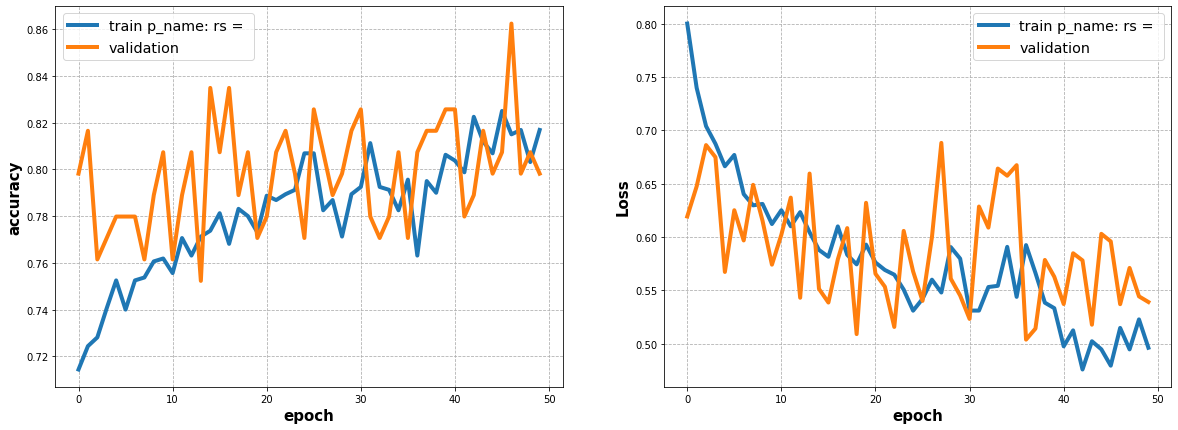

In [200]:
plot_metric(his, 'rs', '')

In [217]:
his = best_model_RS.fit(x_test, y_test, epochs=100, batch_size=64,
                        verbose=0)
loss, accuracy = best_model_RS.evaluate(x_test, y_test, verbose =1)

5/5 [==============================] - 0s 3ms/step - loss: 1.3013 - accuracy: 0.5147


In [191]:
!rm -rf Hyperband_search//////

hypermodel = MyHyperModel(num_classes=8)


In [192]:
from kerastuner.tuners import Hyperband


tuner_hyperband = Hyperband(
    hypermodel,
    max_epochs=20,
    objective='val_accuracy',
    executions_per_trial=2,
    directory='Hyperband_search',
    project_name='speech_rec')

In [193]:
start_time = time.time()
tuner_hyperband.search(x_train, y_train,
             epochs=50,
             validation_data=(x_validation, y_validation), verbose=1)
print("EXECUTION TIME: " + str(time.time()- start_time)) 

Trial 30 Complete [00h 00m 43s]
val_accuracy: 0.15596330165863037

Best val_accuracy So Far: 0.7155963480472565
Total elapsed time: 00h 20m 00s
INFO:tensorflow:Oracle triggered exit
EXECUTION TIME: 1200.1386134624481


In [262]:
# Retrieve the best model.
best_model_hyperband = tuner_hyperband.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model_hyperband.evaluate(x_train, y_train)

50/50 [==============================] - 0s 2ms/step - loss: 0.6563 - accuracy: 0.7806


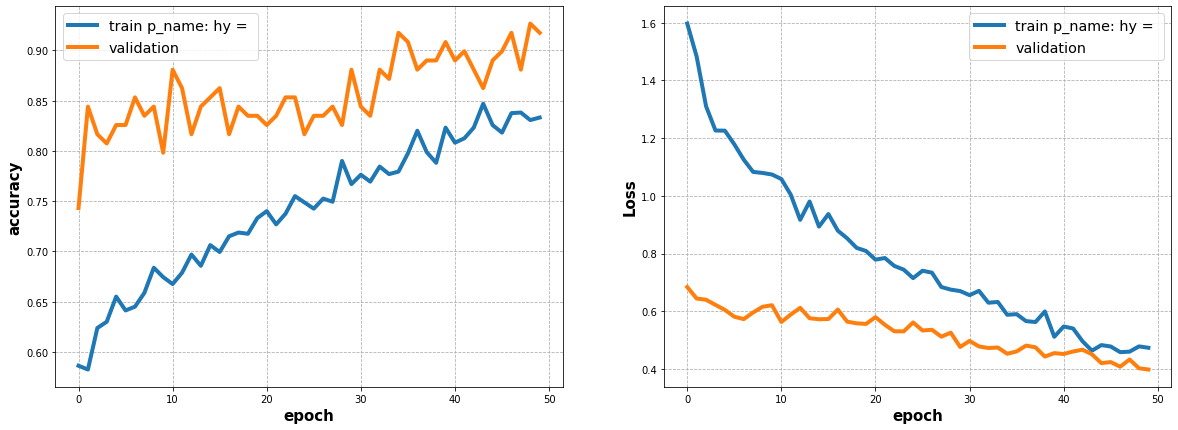

In [263]:
his = best_model_hyperband.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=50, batch_size=128,
                        verbose=0)
plot_metric(his, 'hy', '')

In [264]:
his = best_model_hyperband.fit(x_test, y_test, epochs=100, batch_size=64,verbose=0)
loss, accuracy = best_model_hyperband.evaluate(x_test, y_test, verbose =1)

5/5 [==============================] - 0s 3ms/step - loss: 0.0964 - accuracy: 0.9853


In [235]:
!rm -rf Bayesian_search//////

hypermodel = MyHyperModel(num_classes=8)


In [236]:
tuner_bayesian = BayesianOptimization(
    hypermodel,
    objective='val_accuracy',
    max_trials=20,
    directory='Bayesian_search',
    project_name='speech_rec')


In [237]:
start_time = time.time()
tuner_bayesian.search(x_train, y_train,
             epochs=50,
             validation_data=(x_validation, y_validation), verbose=1)
print("EXECUTION TIME: " + str(time.time()- start_time)) 

Trial 20 Complete [00h 00m 45s]
val_accuracy: 0.5963302850723267

Best val_accuracy So Far: 0.6146789193153381
Total elapsed time: 00h 16m 21s
INFO:tensorflow:Oracle triggered exit
EXECUTION TIME: 981.3243951797485


In [260]:
# Retrieve the best model.
best_model_bayesian = tuner_bayesian.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model_bayesian.evaluate(x_train, y_train)

50/50 [==============================] - 0s 2ms/step - loss: 1.5909 - accuracy: 0.5400


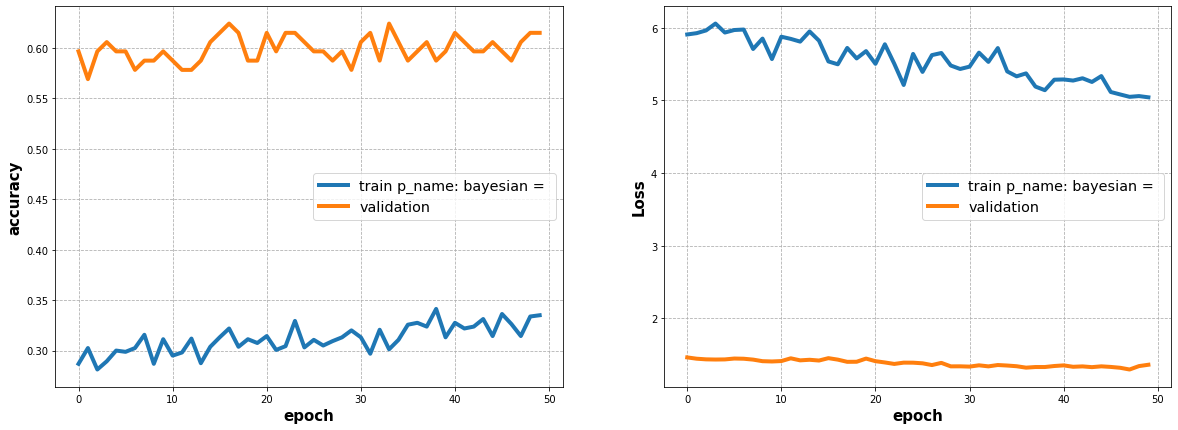

In [251]:
his = best_model_bayesian.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=50, batch_size=128,
                        verbose=0)
plot_metric(his, 'bayesian', '')

In [261]:
his = best_model_bayesian.fit(x_test, y_test, epochs=100, batch_size=64,
                        verbose=0)
loss, accuracy = best_model_bayesian.evaluate(x_test, y_test, verbose =1)

5/5 [==============================] - 0s 3ms/step - loss: 2.8560 - accuracy: 0.3603
